In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import librosa.display
from sklearn import metrics
from glob import glob
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display
import noisereduce as nr
import io
import time
from tqdm import tqdm
from scipy.stats import kurtosis
from tabulate import tabulate
from keras.utils import load_img, img_to_array
from joblib import load
import PIL
from PIL import Image

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
ENTERFACE_DIR = './../../../eNTERFACE05_Dataset/'
ENTERFACE_EXTRACTED_FEATURES_FILE = './../../enterface05/final_data/traditional/final_preprocessed_extracted_features_ent05.csv'
EMODB_DIR = './../../../EMO-DB_Dataset/wav/'
EMODB_EXTRACTED_FEATURES_FILE = './../../emodb/traditional/preprocessed_extracted_features_emodb.csv'
CREMAD_DIR = './../../../CREMA-D_Dataset/AudioWAV/'
CREMAD_EXTRACTED_FEATURES_FILE = './../../cremad/traditional/preprocessed_extracted_features_cremad.csv'
plt.rcParams['figure.dpi'] = 300

In [3]:
def get_metrics(y_labels, y_pred, times, draw_corr_matrix=True):
    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Average Prediction Time",
            f"{round(np.mean(times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - sad', '3 - neutral']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()




In [4]:
def preprocess_audio(y, sr):
    y = nr.reduce_noise(y=y, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)
    y, _ = librosa.effects.trim(y, top_db=30)
    return y
    
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1
    
    return num_spikes

def extract_features(audio_file, preprocess=True): 
    y, sr = librosa.load(audio_file, sr=16000)
    
    if preprocess:
        y = preprocess_audio(y, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    zcr = librosa.feature.zero_crossing_rate(y=y)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=127)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    min_zcr = np.min(zcr)
    spikes_zcr = spikes(zcr)
    var_mel_spect = np.var(mel_spect)
    spikes_mel_spect = spikes(mel_spect)
    thpercentile25_chroma_stft = np.percentile(chroma_stft, 0.25)
    spikes_chroma_stft = spikes(chroma_stft)
    mean_spec_bw = np.mean(spec_bw)
    max_spec_bw = np.max(spec_bw)
    thpercentile25_rms = np.percentile(librosa.feature.rms(y=y), 0.25)

    var_mfcc1 = np.var(mfcc[0])
    var_mfcc3 = np.var(mfcc[2])
    max_mfcc5 = np.max(mfcc[4])
    var_mfcc5 = np.var(mfcc[4])
    median_mfcc5 = np.median(mfcc[4])
    spikes_mfcc6 = spikes(mfcc[5])
    thpercentile75_mfcc7 = np.percentile(mfcc[6], 0.75)
    max_mfcc7 = np.max(mfcc[6])
    var_mfcc8 = np.var(mfcc[7])
    sum_mfcc10 = np.sum(mfcc[9])
    max_mfcc10 = np.max(mfcc[9])
    thpercentile75_mfcc11 = np.percentile(mfcc[10], 0.75)
    max_mfcc11 = np.max(mfcc[10])
    sum_mfcc12 = np.sum(mfcc[11])
    kurtosis_mfcc12 = kurtosis(mfcc[11])
    mean_mfcc13 = np.mean(mfcc[12])
    mean_mfcc15 = np.mean(mfcc[14])
    spikes_mfcc16 = spikes(mfcc[15])
    kurtosis_mfcc17 = kurtosis(mfcc[16])
    mean_mfcc17 = np.mean(mfcc[16])
    kurtosis_mfcc18 = kurtosis(mfcc[17])
    spikes_mfcc19 = spikes(mfcc[18])
    mean_mfcc19 = np.mean(mfcc[18])
    mean_mfcc20 = np.mean(mfcc[19])

    return np.array([min_zcr, spikes_zcr, var_mel_spect, spikes_mel_spect, thpercentile25_chroma_stft,
        spikes_chroma_stft, mean_spec_bw, max_spec_bw, thpercentile25_rms, var_mfcc1, var_mfcc3, max_mfcc5,
        var_mfcc5, median_mfcc5, spikes_mfcc6, thpercentile75_mfcc7, max_mfcc7, var_mfcc8,
        sum_mfcc10, max_mfcc10, thpercentile75_mfcc11, max_mfcc11, sum_mfcc12, kurtosis_mfcc12,
        mean_mfcc13, mean_mfcc15, spikes_mfcc16, kurtosis_mfcc17, mean_mfcc17, kurtosis_mfcc18,
        spikes_mfcc19, mean_mfcc19, mean_mfcc20]).reshape(1, -1)

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0, dpi=100)
    buf.seek(0)
    return Image.open(buf).convert('RGB').resize((224, 224), PIL.Image.NEAREST)

def extract_dl_features(audio_file, preprocess=True): 
    y, sr = librosa.load(audio_file, sr=16000)

    if preprocess:
        y = preprocess_audio(y, sr)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(y,  n_fft=2048, hop_length=512)), ref=np.max)
    librosa.display.specshow(spec, sr=sr, hop_length=512, ax=ax, cmap="viridis_r")
    img = fig2img(fig)
    fig.clf()
    plt.close(fig)

    return tf.keras.applications.resnet50.preprocess_input(
        img_to_array(img)).reshape((1, 224, 224, 3))


# eNTERFACE'05

In [23]:
emotion_number = {
    'anger': 0, 'happiness': 1, 'sadness': 2
}

print(f"Number of Audio Files: {pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 630


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
happiness,1,210
sadness,2,210


In [6]:
print(tabulate(pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id"), headers=["Emotion", "Number of Files"], tablefmt='latex_booktabs'))

\begin{tabular}{lr}
\toprule
 Emotion          &   Number of Files \\
\midrule
 ('anger', 0)     &               210 \\
 ('happiness', 1) &               210 \\
 ('sadness', 2)   &               210 \\
\bottomrule
\end{tabular}


## Traditional Model

100%|██████████| 1260/1260 [02:25<00:00,  8.64it/s]
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa


Metric                     Value
-----------------------  -------
Accuracy                  29.37
F1 score macro            18.61
Precision                 17.85
Recall                    22.02
Matthews corrcoef          0.064
Average Prediction Time    0.23

              precision    recall  f1-score   support

           0       0.42      0.70      0.52       210
           1       0.30      0.18      0.22       210
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00         0

    accuracy                           0.29       630
   macro avg       0.18      0.22      0.19       630
weighted avg       0.24      0.29      0.25       630



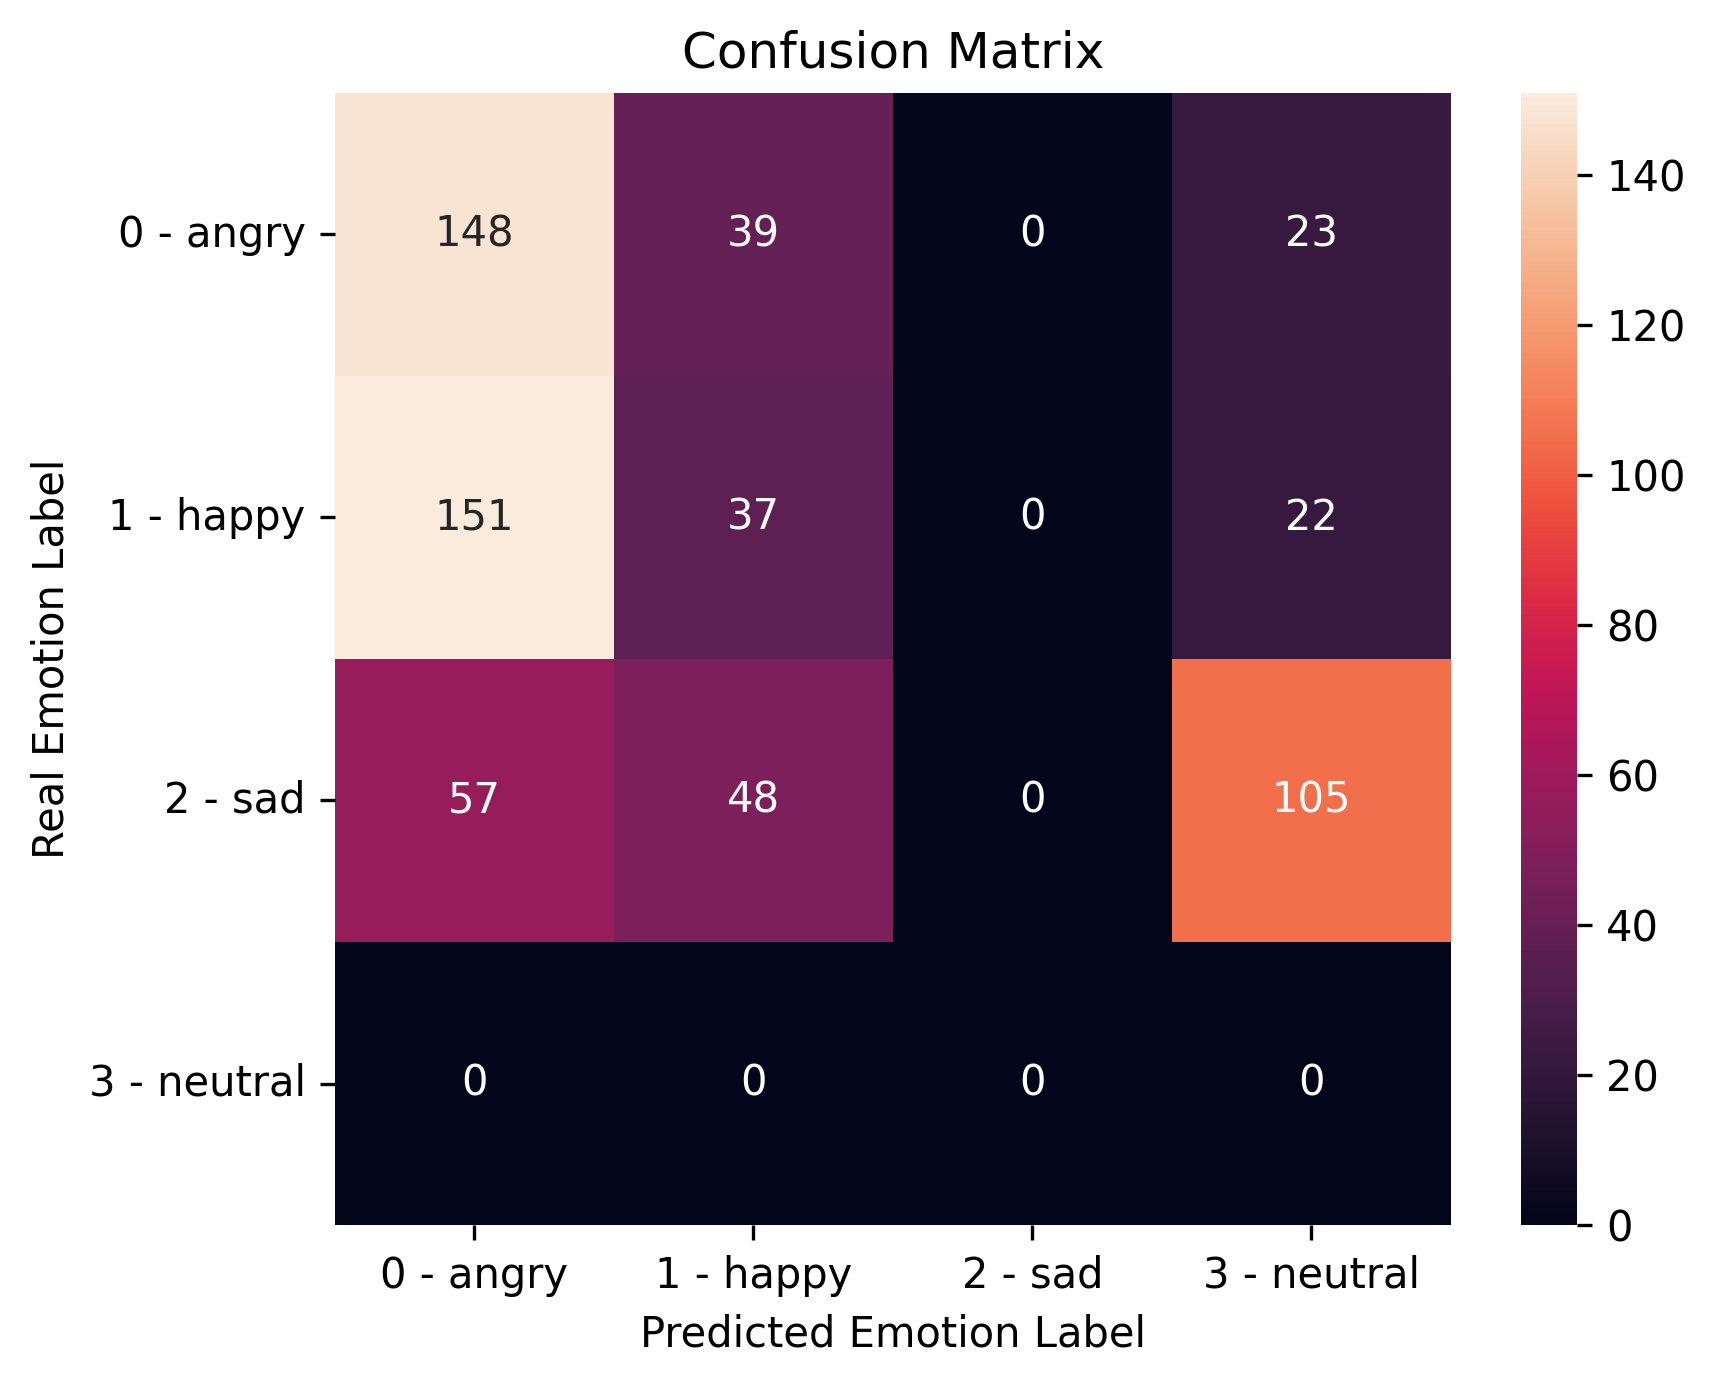

In [94]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob("../../../eNTERFACE05_Dataset/*/*/*/*.wav")):
    emotion = file_path.split('\\')[-3]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

## Stratified Traditional Model


Metric                     Value
-----------------------  -------
Accuracy                  29.68
F1 score macro            18.82
Precision                 40.7
Recall                    22.26
Matthews corrcoef          0.025
Average Prediction Time    0.07

              precision    recall  f1-score   support

           0       0.40      0.69      0.50       210
           1       0.23      0.18      0.20       210
           2       1.00      0.02      0.05       210
           3       0.00      0.00      0.00         0

    accuracy                           0.30       630
   macro avg       0.41      0.22      0.19       630
weighted avg       0.54      0.30      0.25       630



C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Us

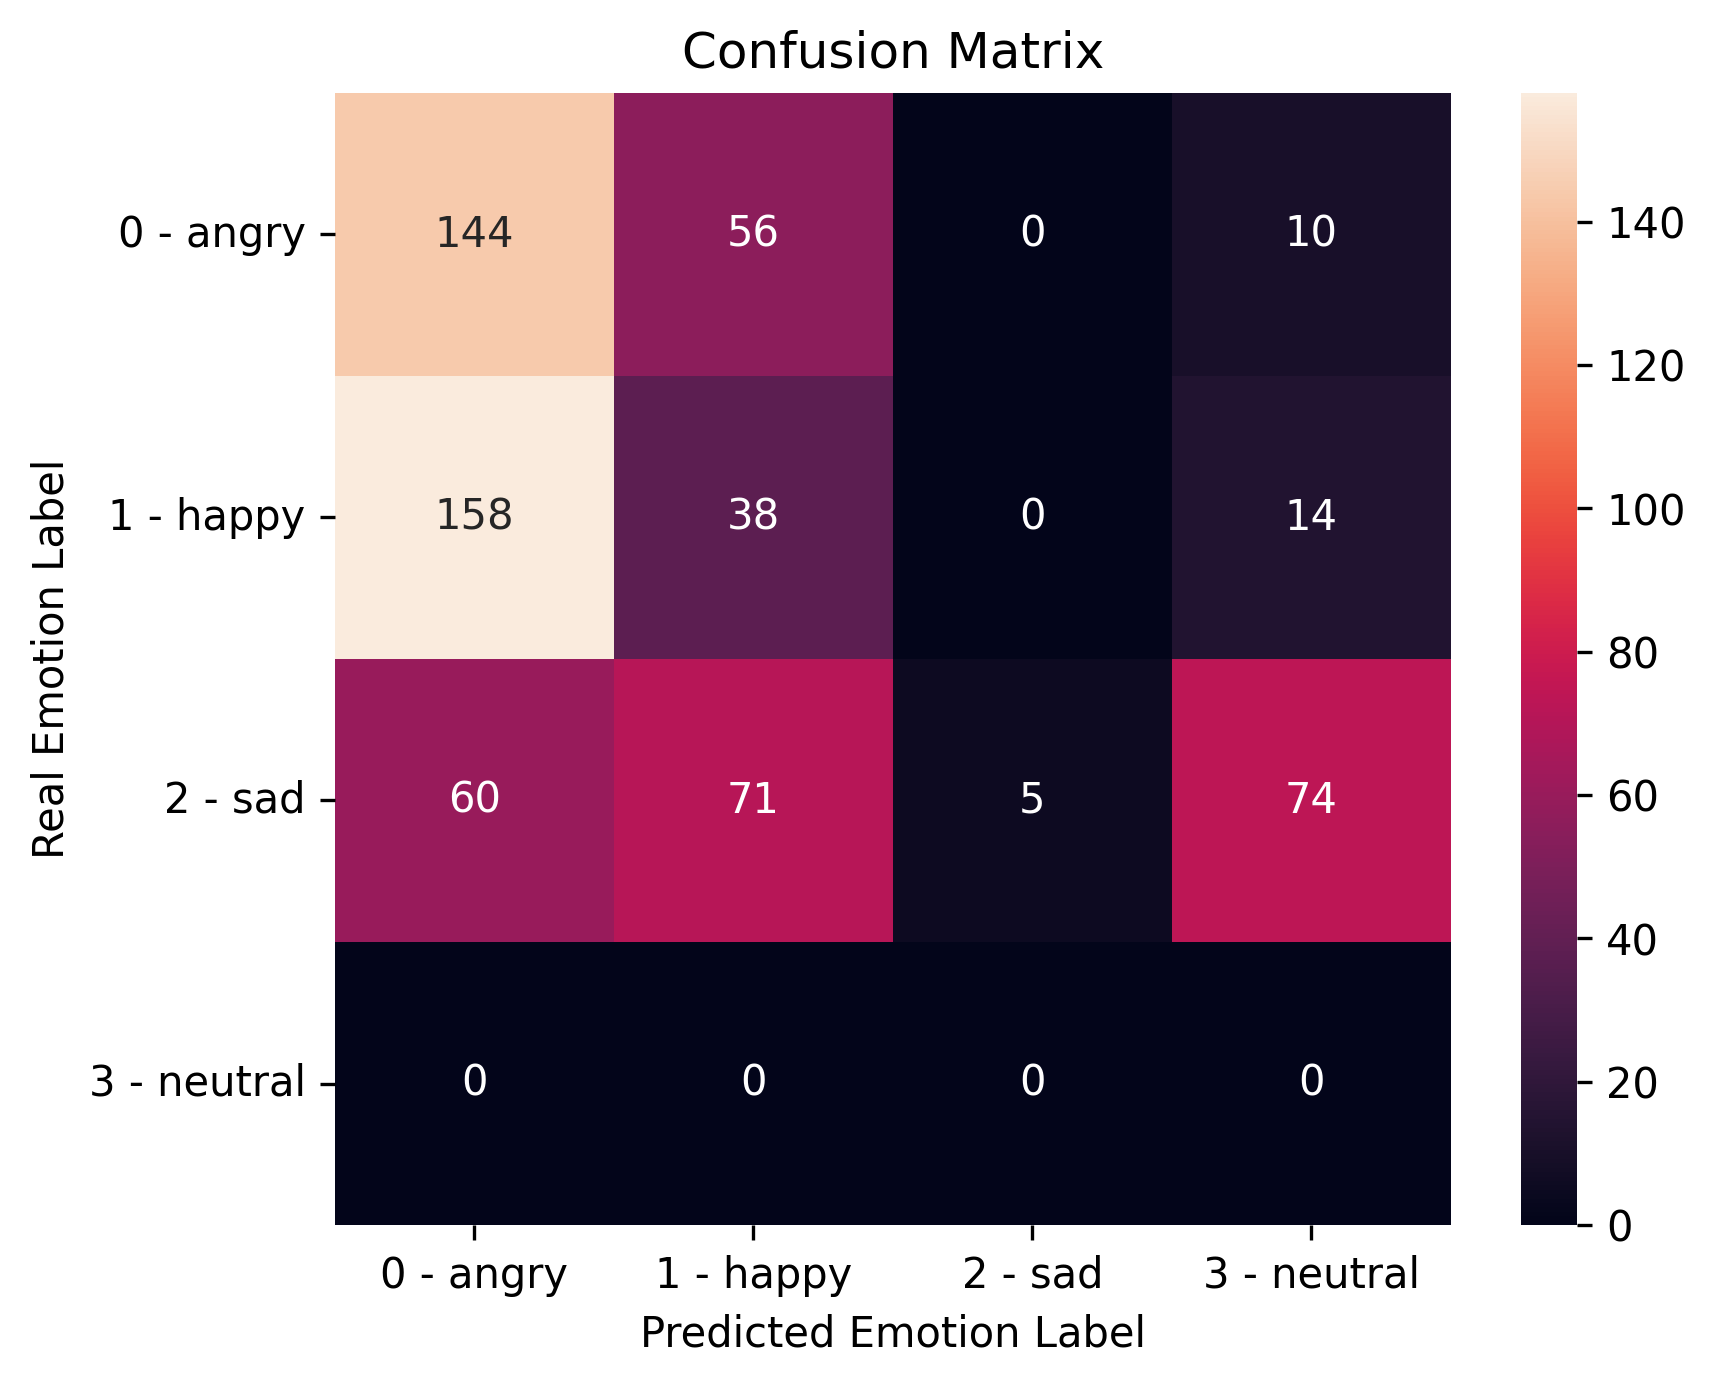

In [35]:
model = load('stratified_traditional_model.pkl')

df = pd.read_csv(ENTERFACE_EXTRACTED_FEATURES_FILE)
y = df.iloc[:, 5:6]
x = df.iloc[:, 6:]
times = []

start_time = time.time()
pred = model.predict(x)
times.append(time.time() - start_time)

get_metrics(y, pred, times)

## Deep Learning Model

100%|██████████| 1260/1260 [02:36<00:00,  8.03it/s]


Metric                     Value
-----------------------  -------
Accuracy                  36.67
F1 score macro            22.91
Precision                 44.36
Recall                    27.5
Matthews corrcoef          0.087
Average Prediction Time    0.25

              precision    recall  f1-score   support

           0       0.42      0.62      0.50       210
           1       0.35      0.48      0.40       210
           2       1.00      0.00      0.01       210
           3       0.00      0.00      0.00         0

    accuracy                           0.37       630
   macro avg       0.44      0.28      0.23       630
weighted avg       0.59      0.37      0.31       630




C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

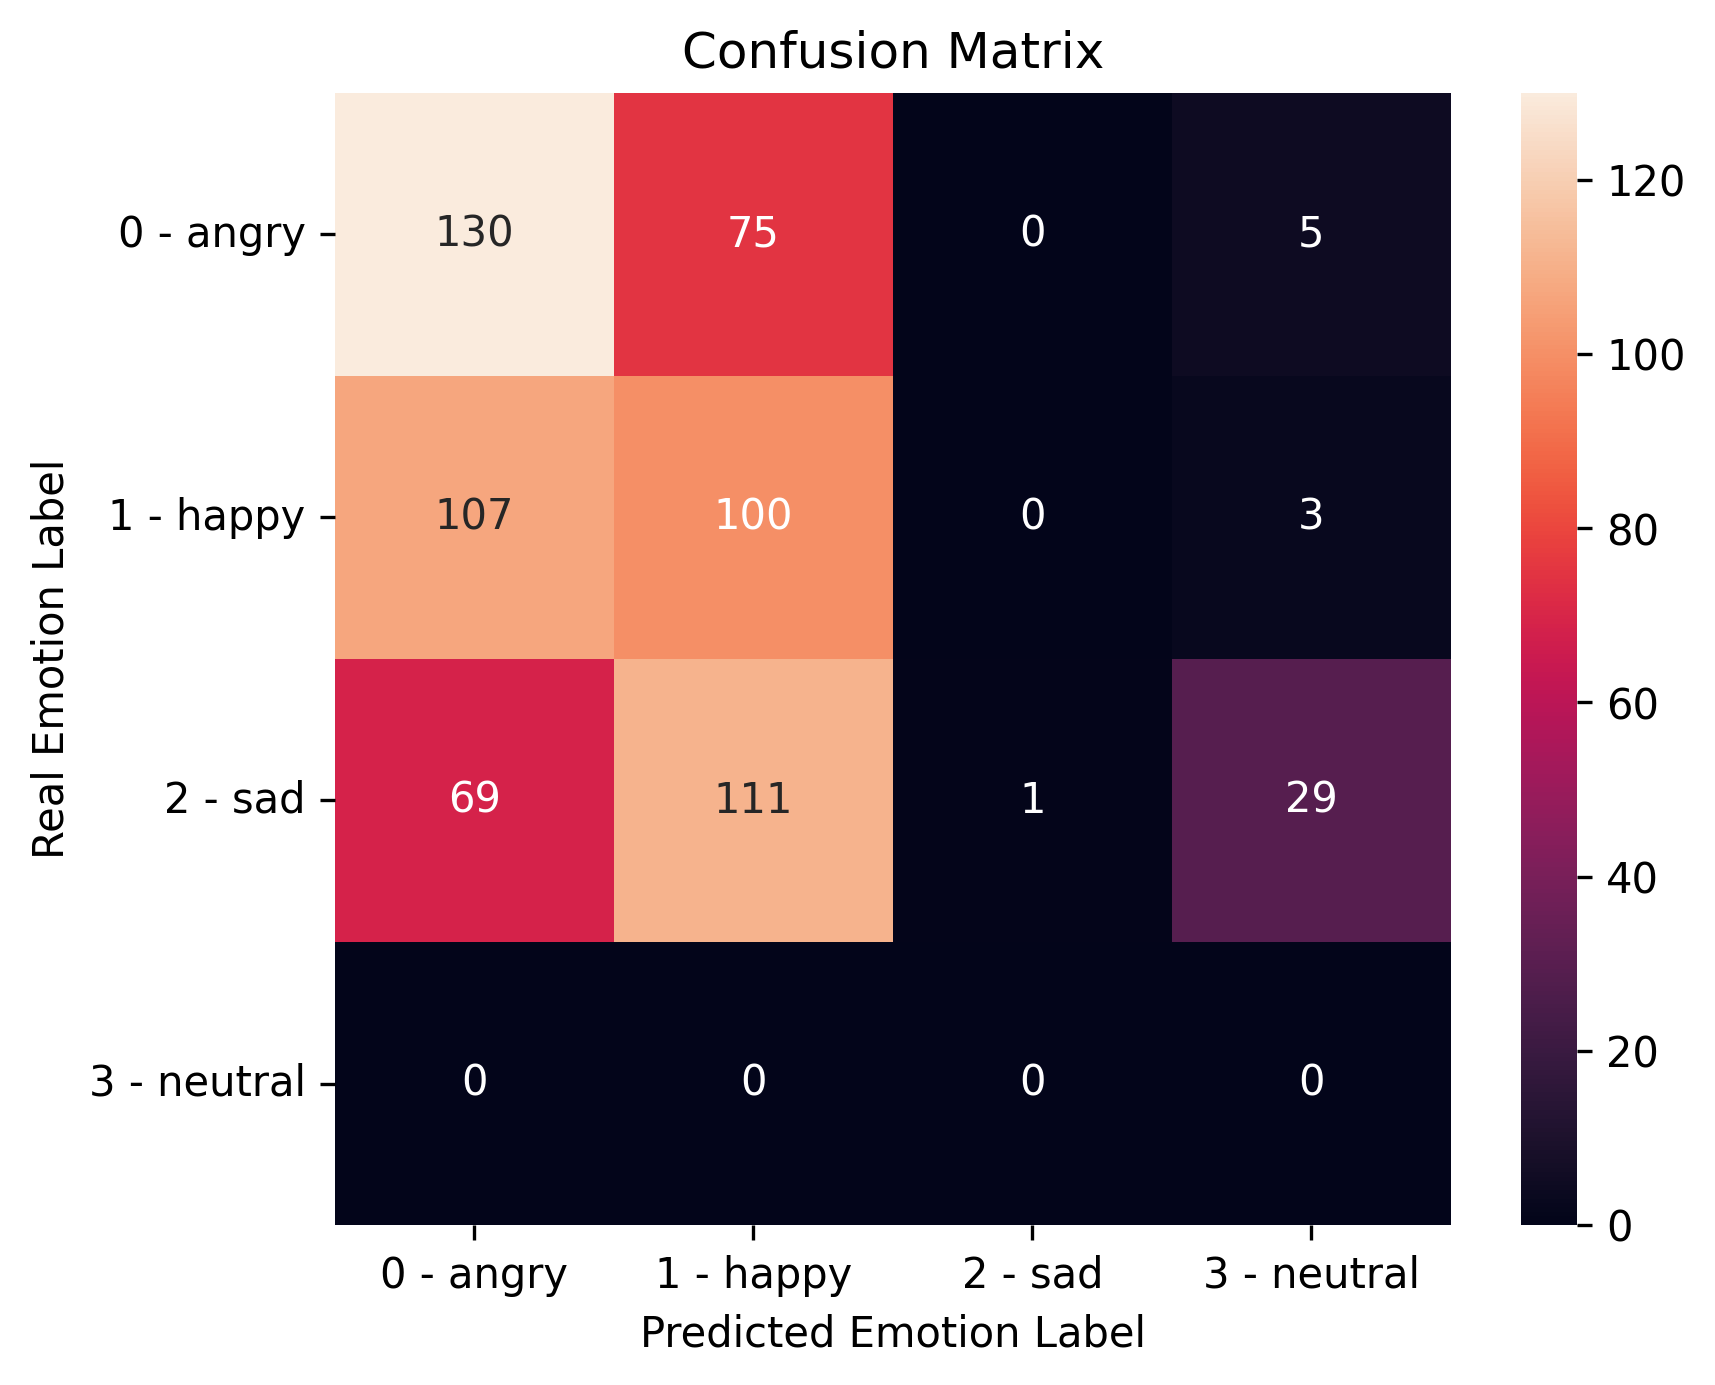

In [10]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob("../../../eNTERFACE05_Dataset/*/*/*/*.wav")):
    emotion = file_path.split('\\')[-3]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    pred = list(pred).index(max(pred))
    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

## Stratified Deep Learning Model

100%|██████████| 1260/1260 [02:38<00:00,  7.93it/s]
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_


Metric                     Value
-----------------------  -------
Accuracy                  37.14
F1 score macro            22.39
Precision                 43.51
Recall                    27.86
Matthews corrcoef          0.073
Average Prediction Time    0.25

              precision    recall  f1-score   support

           0       0.42      0.69      0.52       210
           1       0.32      0.42      0.36       210
           2       1.00      0.00      0.01       210
           3       0.00      0.00      0.00         0

    accuracy                           0.37       630
   macro avg       0.44      0.28      0.22       630
weighted avg       0.58      0.37      0.30       630



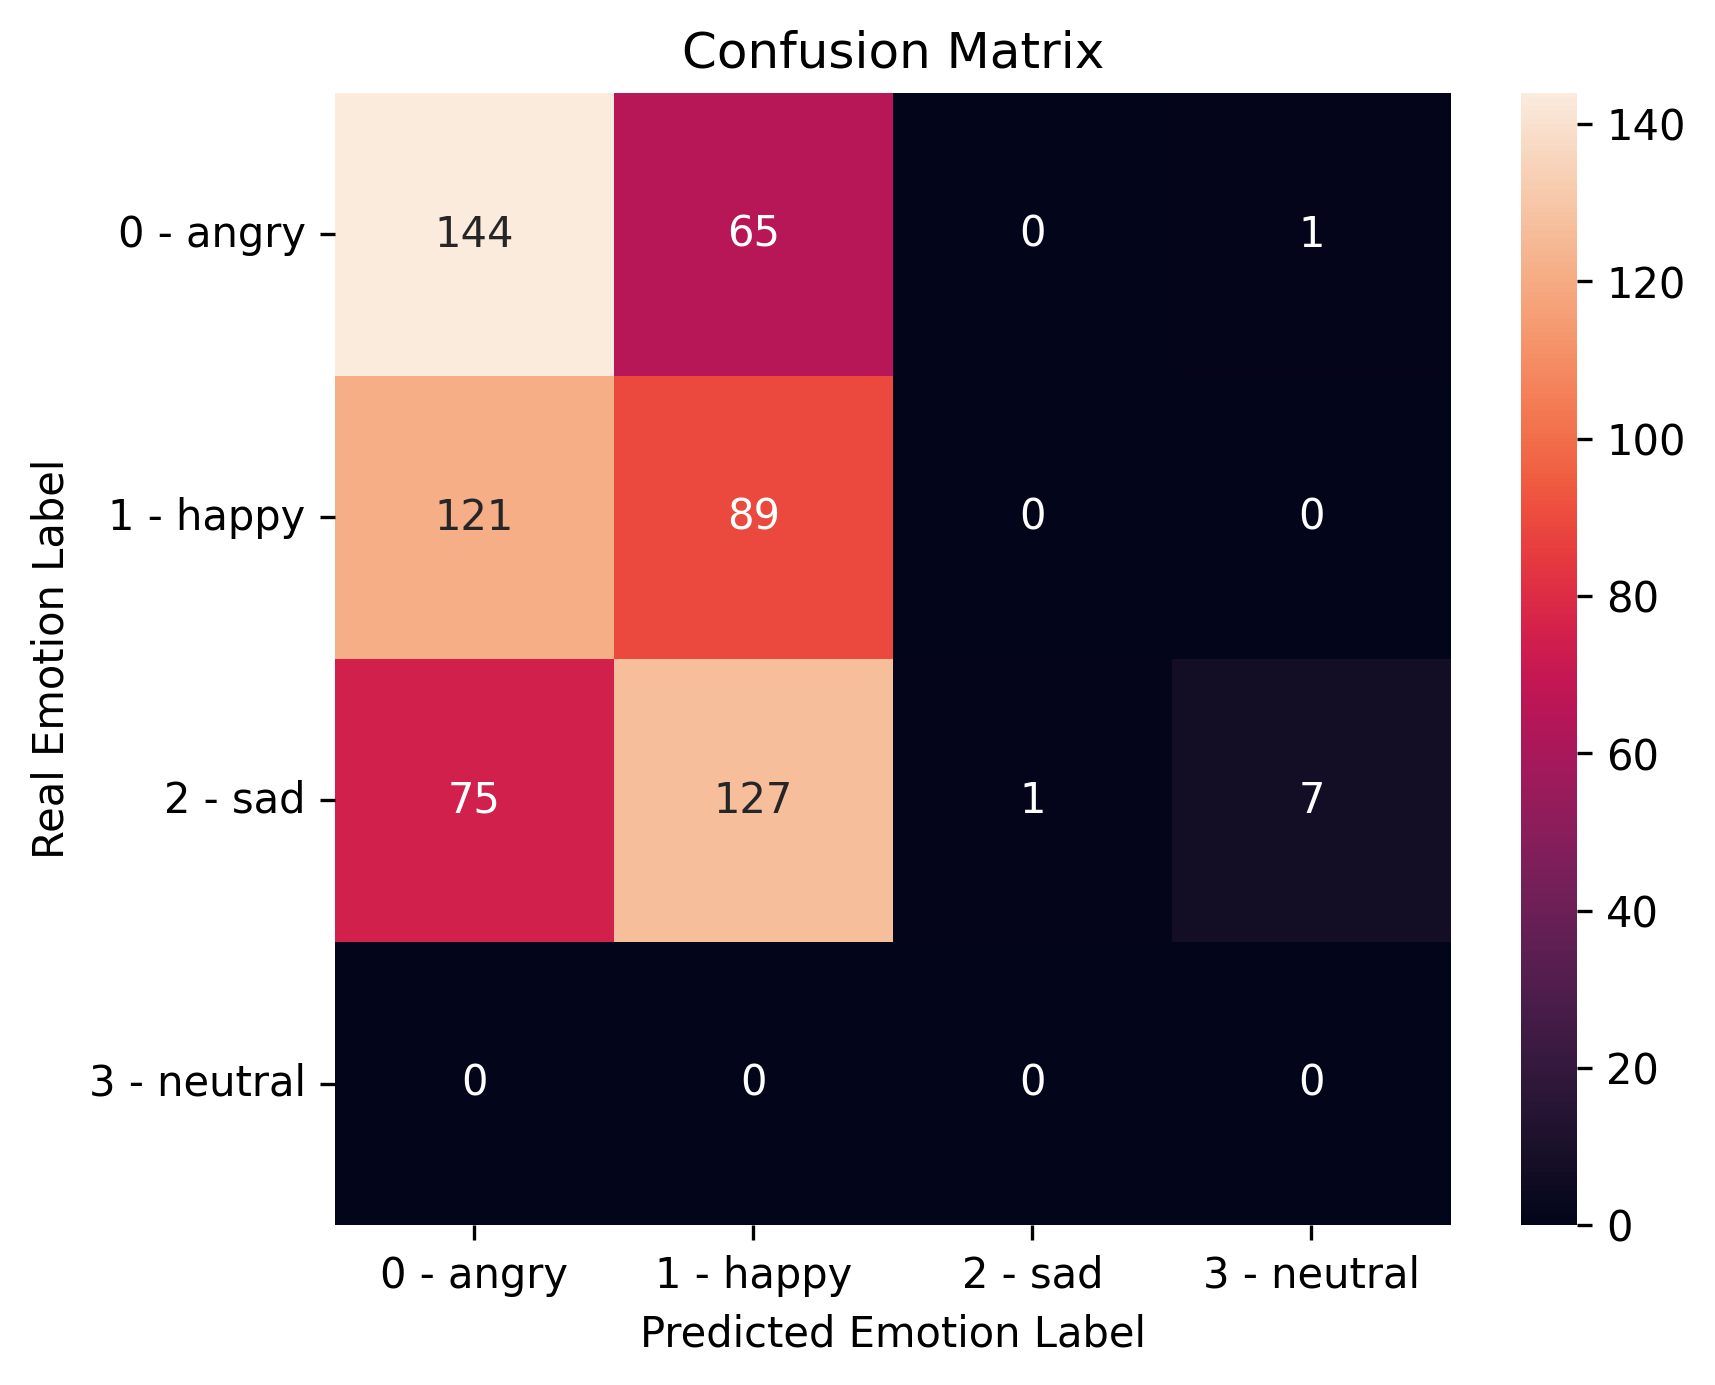

In [6]:
model = tf.keras.models.load_model('stratified_dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob("../../../eNTERFACE05_Dataset/*/*/*/*.wav")):
    emotion = file_path.split('\\')[-3]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    pred = list(pred).index(max(pred))
    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

# EMO-DB

In [7]:
emotion_number = {
    'W': 0, 'F': 1, 'T': 2, 'N': 3
}

print(f"Number of Audio Files: {pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 339


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,127
happy,1,71
sad,2,62
neutral,3,79


In [12]:
print(tabulate(pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id"), headers=["Emotion", "Number of Files"], tablefmt='latex_booktabs'))

\begin{tabular}{lr}
\toprule
 Emotion        &   Number of Files \\
\midrule
 ('anger', 0)   &               127 \\
 ('happy', 1)   &                71 \\
 ('sad', 2)     &                62 \\
 ('neutral', 3) &                79 \\
\bottomrule
\end{tabular}


## Traditional Model

100%|██████████| 535/535 [00:36<00:00, 14.48it/s]


Metric                     Value
-----------------------  -------
Accuracy                  38.94
F1 score macro            17.36
Precision                 25.75
Recall                    26.72
Matthews corrcoef          0.087
Average Prediction Time    0.11

              precision    recall  f1-score   support

           0       0.42      1.00      0.60       127
           1       0.11      0.06      0.07        71
           2       0.00      0.00      0.00        62
           3       0.50      0.01      0.02        79

    accuracy                           0.39       339
   macro avg       0.26      0.27      0.17       339
weighted avg       0.30      0.39      0.24       339




C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

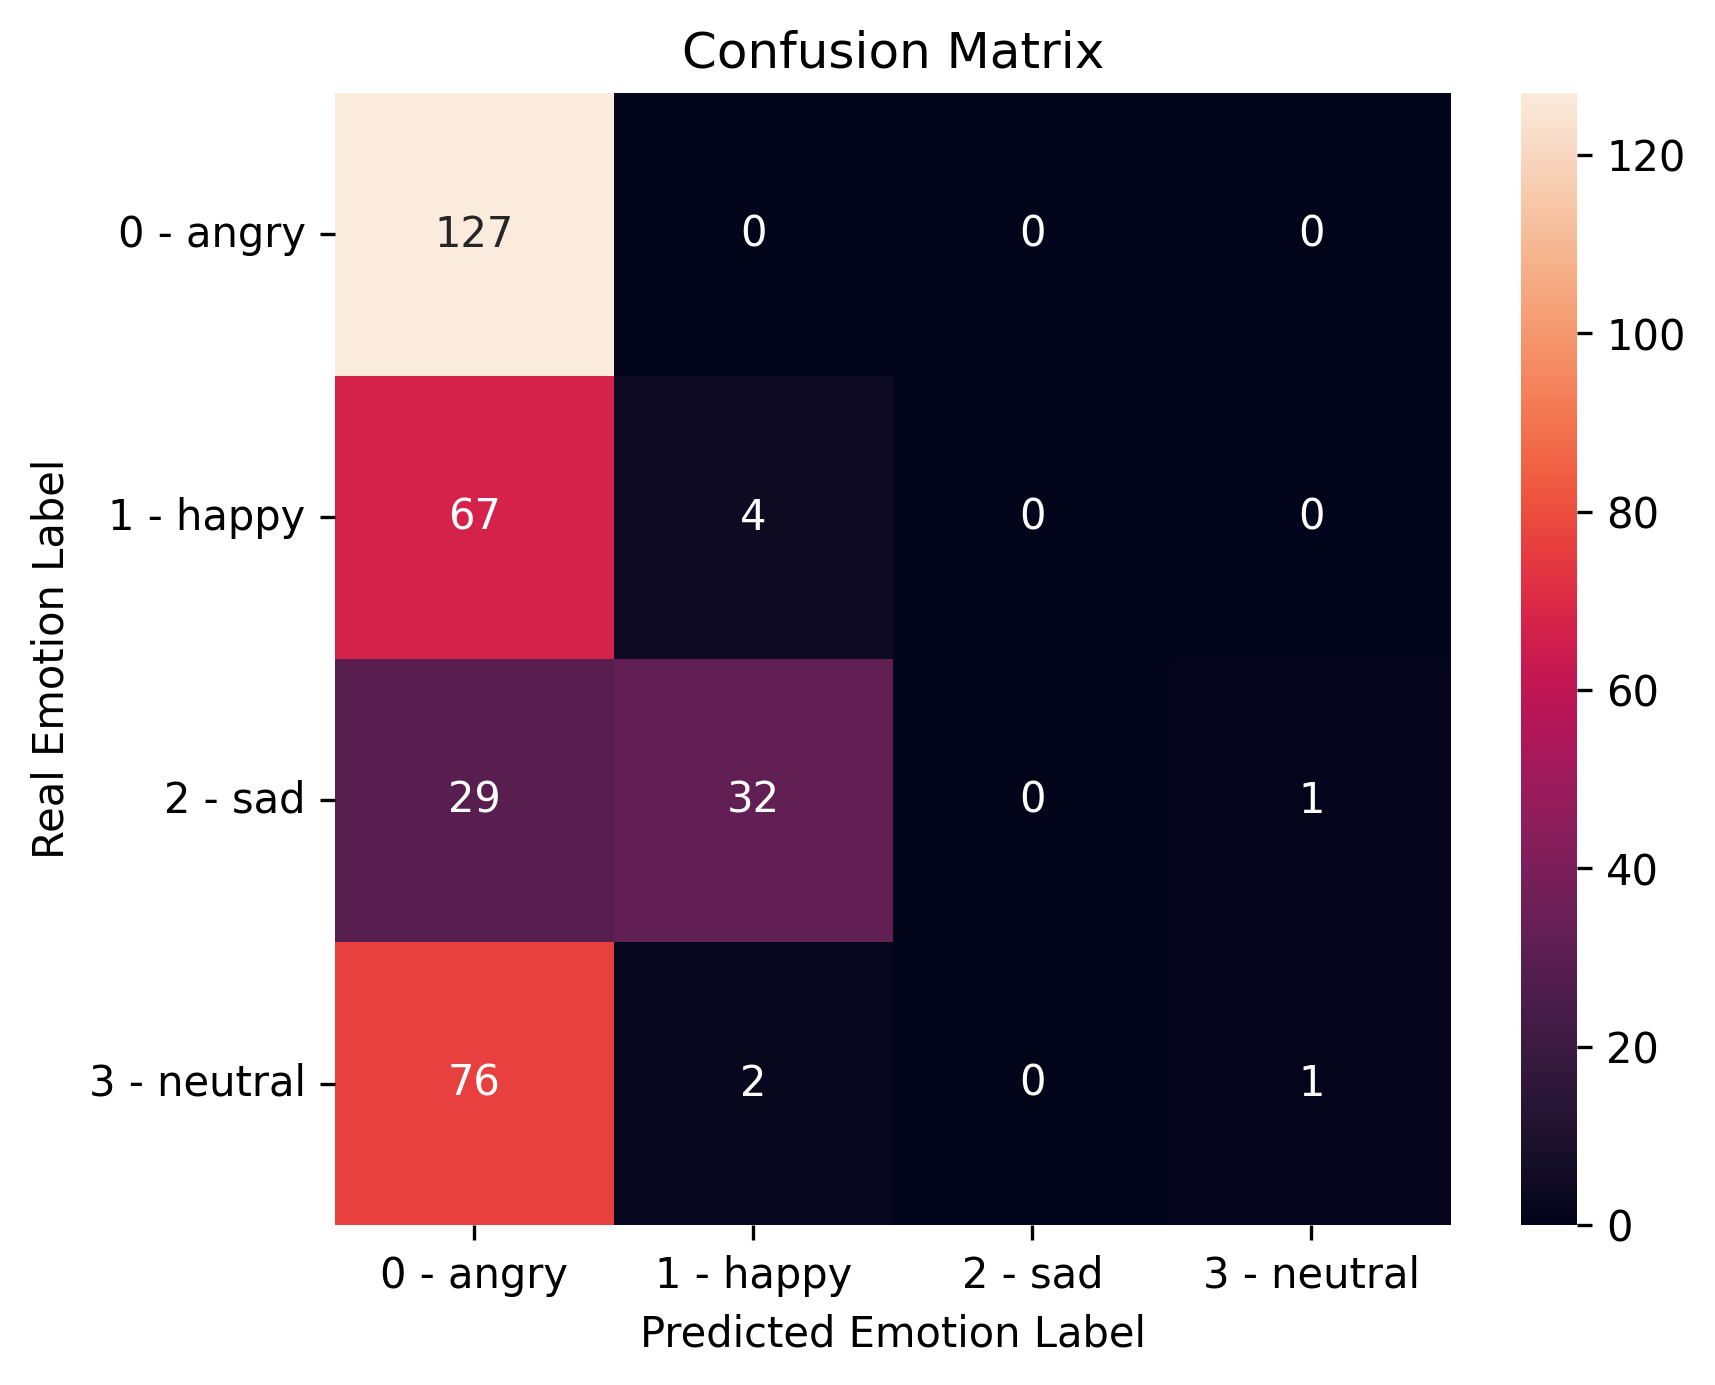

In [13]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{EMODB_DIR}*.wav")):
    emotion = file_path[-6:-5]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)


C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMet


Metric                     Value
-----------------------  -------
Accuracy                  38.94
F1 score macro            17.36
Precision                 25.75
Recall                    26.72
Matthews corrcoef          0.087
Average Prediction Time    0.11

              precision    recall  f1-score   support

           0       0.42      1.00      0.60       127
           1       0.11      0.06      0.07        71
           2       0.00      0.00      0.00        62
           3       0.50      0.01      0.02        79

    accuracy                           0.39       339
   macro avg       0.26      0.27      0.17       339
weighted avg       0.30      0.39      0.24       339



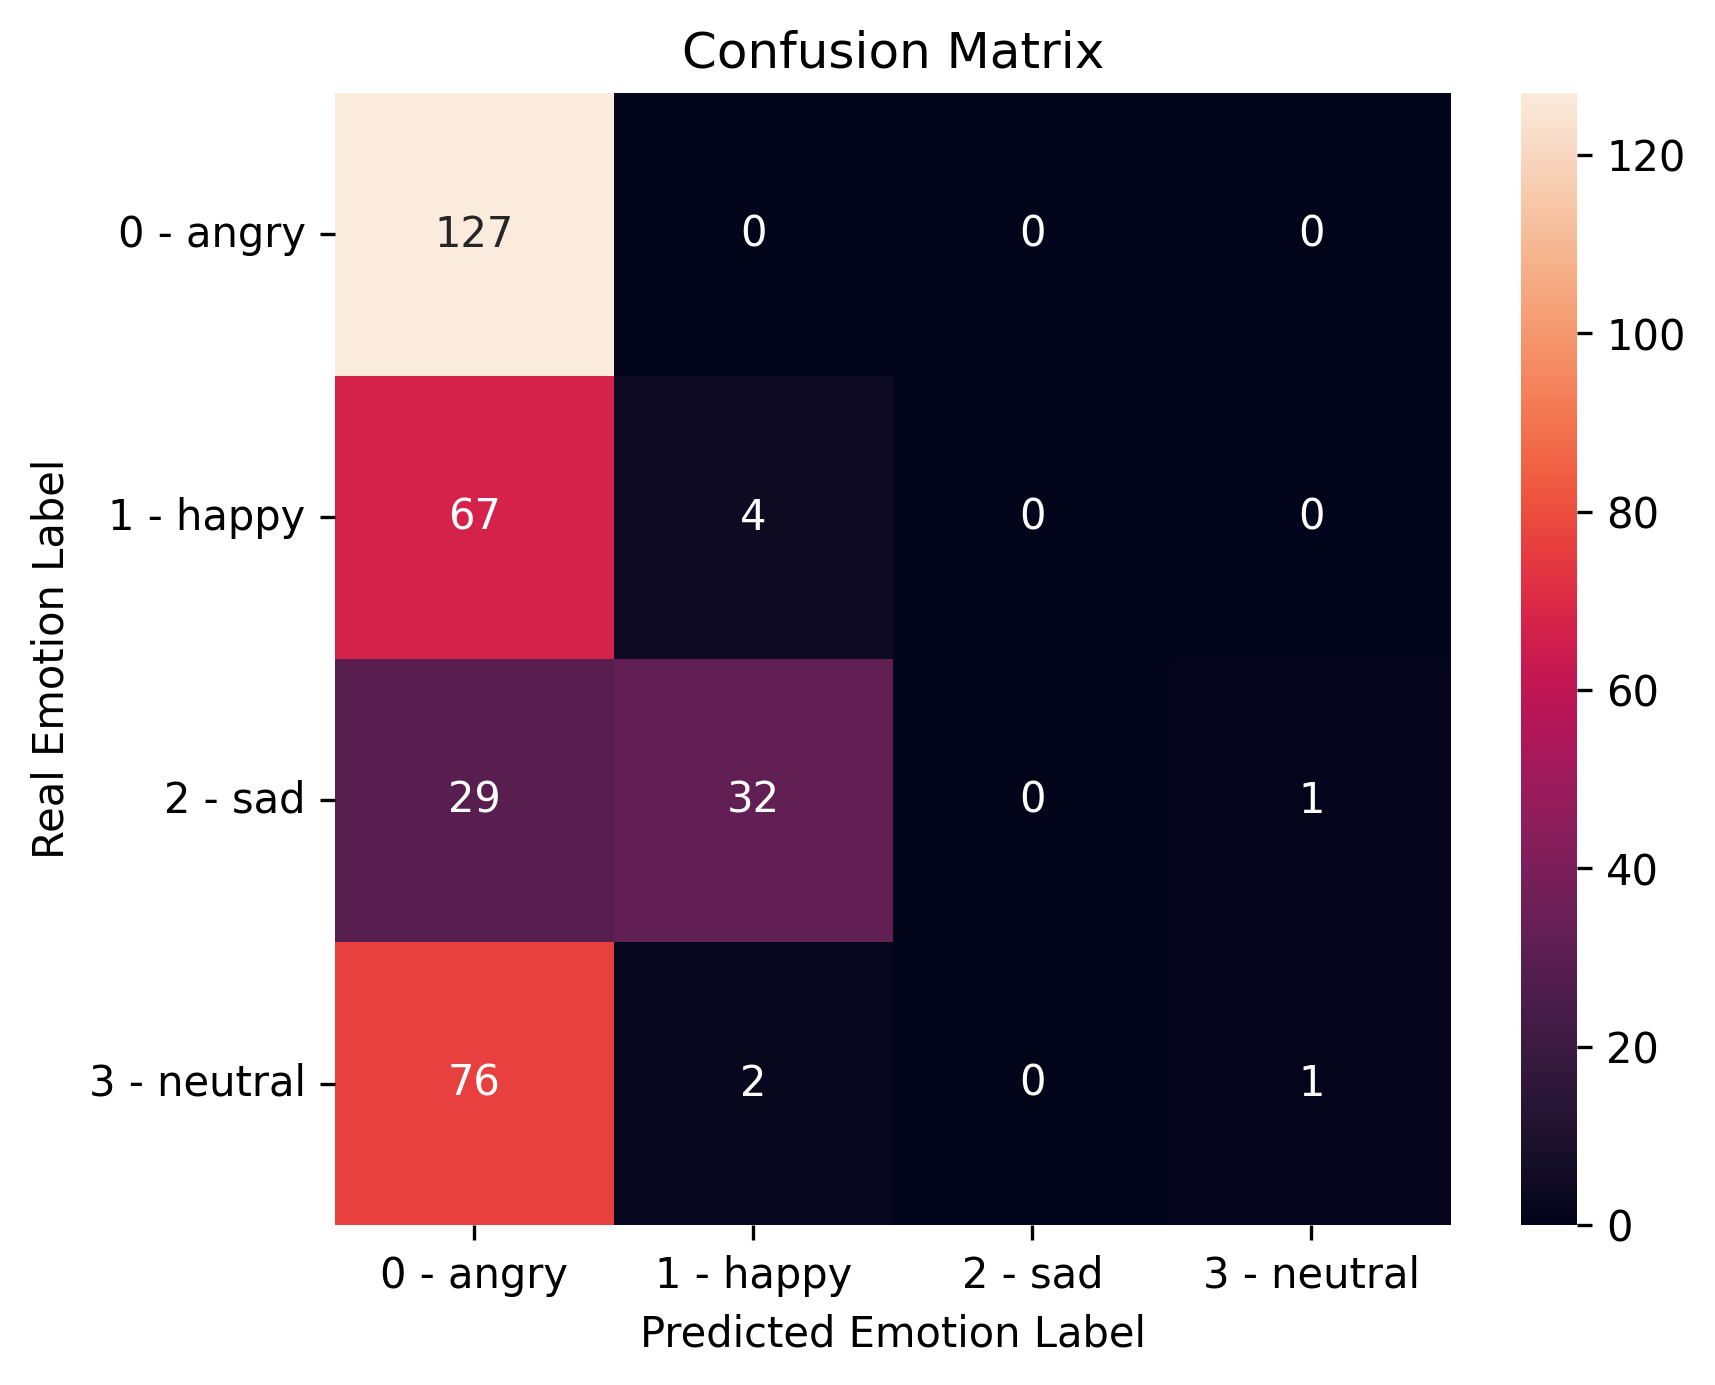

In [14]:
model = load('traditional_model.pkl')

df = pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE)
y = df.iloc[:, 4:5]
x = df.iloc[:, 5:]

start_time = time.time()
pred = model.predict(x)
times.append(time.time() - start_time)

get_metrics(y, pred, times)

## Stratified Traditional Model

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMet


Metric                     Value
-----------------------  -------
Accuracy                  40.41
F1 score macro            20.24
Precision                 31.93
Recall                    28.61
Matthews corrcoef          0.126
Average Prediction Time    0.64

              precision    recall  f1-score   support

           0       0.45      0.99      0.62       127
           1       0.16      0.13      0.14        71
           2       0.00      0.00      0.00        62
           3       0.67      0.03      0.05        79

    accuracy                           0.40       339
   macro avg       0.32      0.29      0.20       339
weighted avg       0.36      0.40      0.27       339



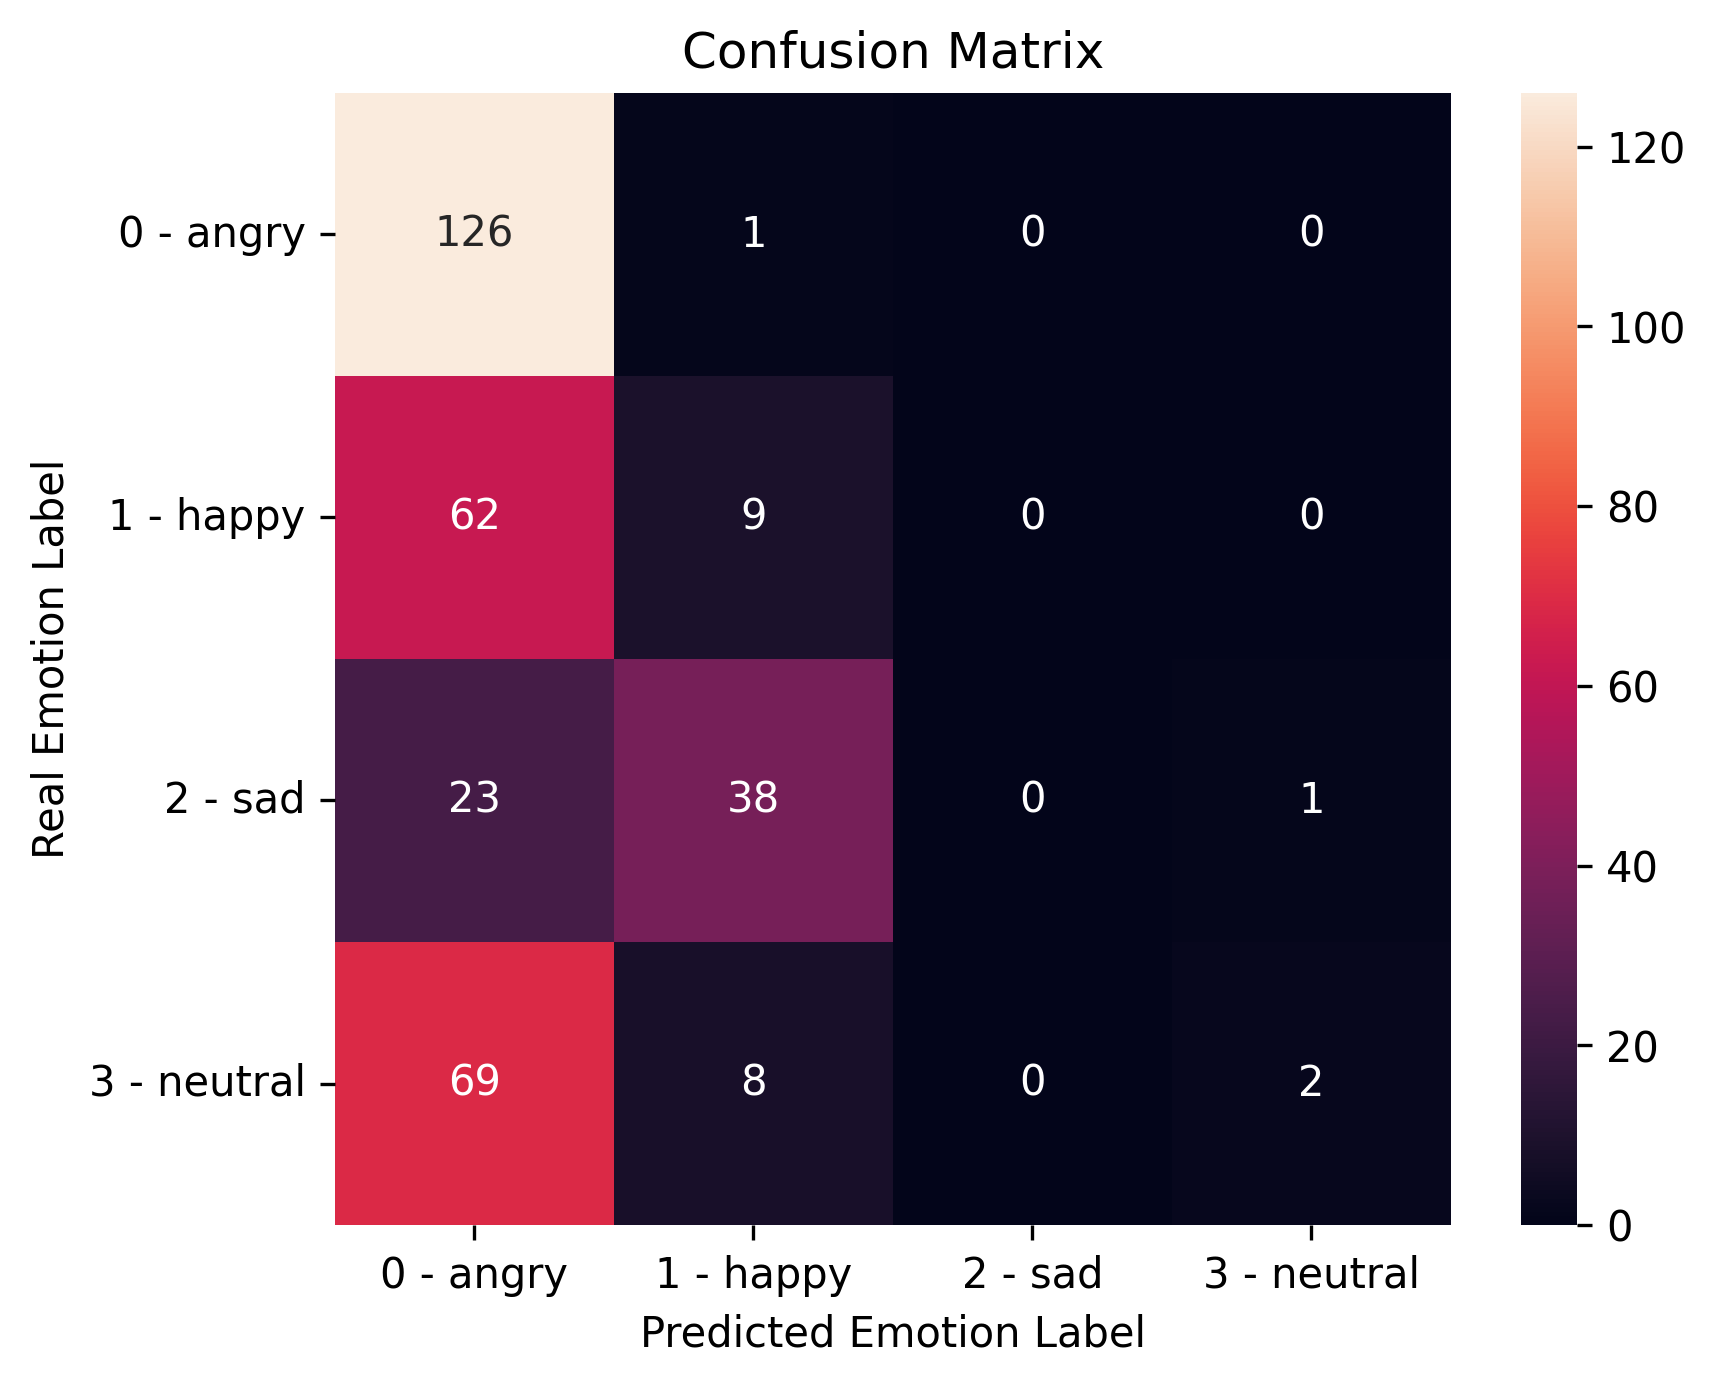

In [52]:
model = load('stratified_traditional_model.pkl')

df = pd.read_csv(EMODB_EXTRACTED_FEATURES_FILE)
y = df.iloc[:, 4:5]
x = df.iloc[:, 5:]

start_time = time.time()
pred = model.predict(x)
times.append(time.time() - start_time)

get_metrics(y, pred, times)

## Deep Learning Model

100%|██████████| 535/535 [01:02<00:00,  8.53it/s]


Metric                     Value
-----------------------  -------
Accuracy                  38.35
F1 score macro            15.79
Precision                 37.78
Recall                    25.99
Matthews corrcoef          0.066
Average Prediction Time    0.18

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       127
           1       0.12      0.01      0.03        71
           2       0.00      0.00      0.00        62
           3       1.00      0.03      0.05        79

    accuracy                           0.38       339
   macro avg       0.38      0.26      0.16       339
weighted avg       0.40      0.38      0.23       339




C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

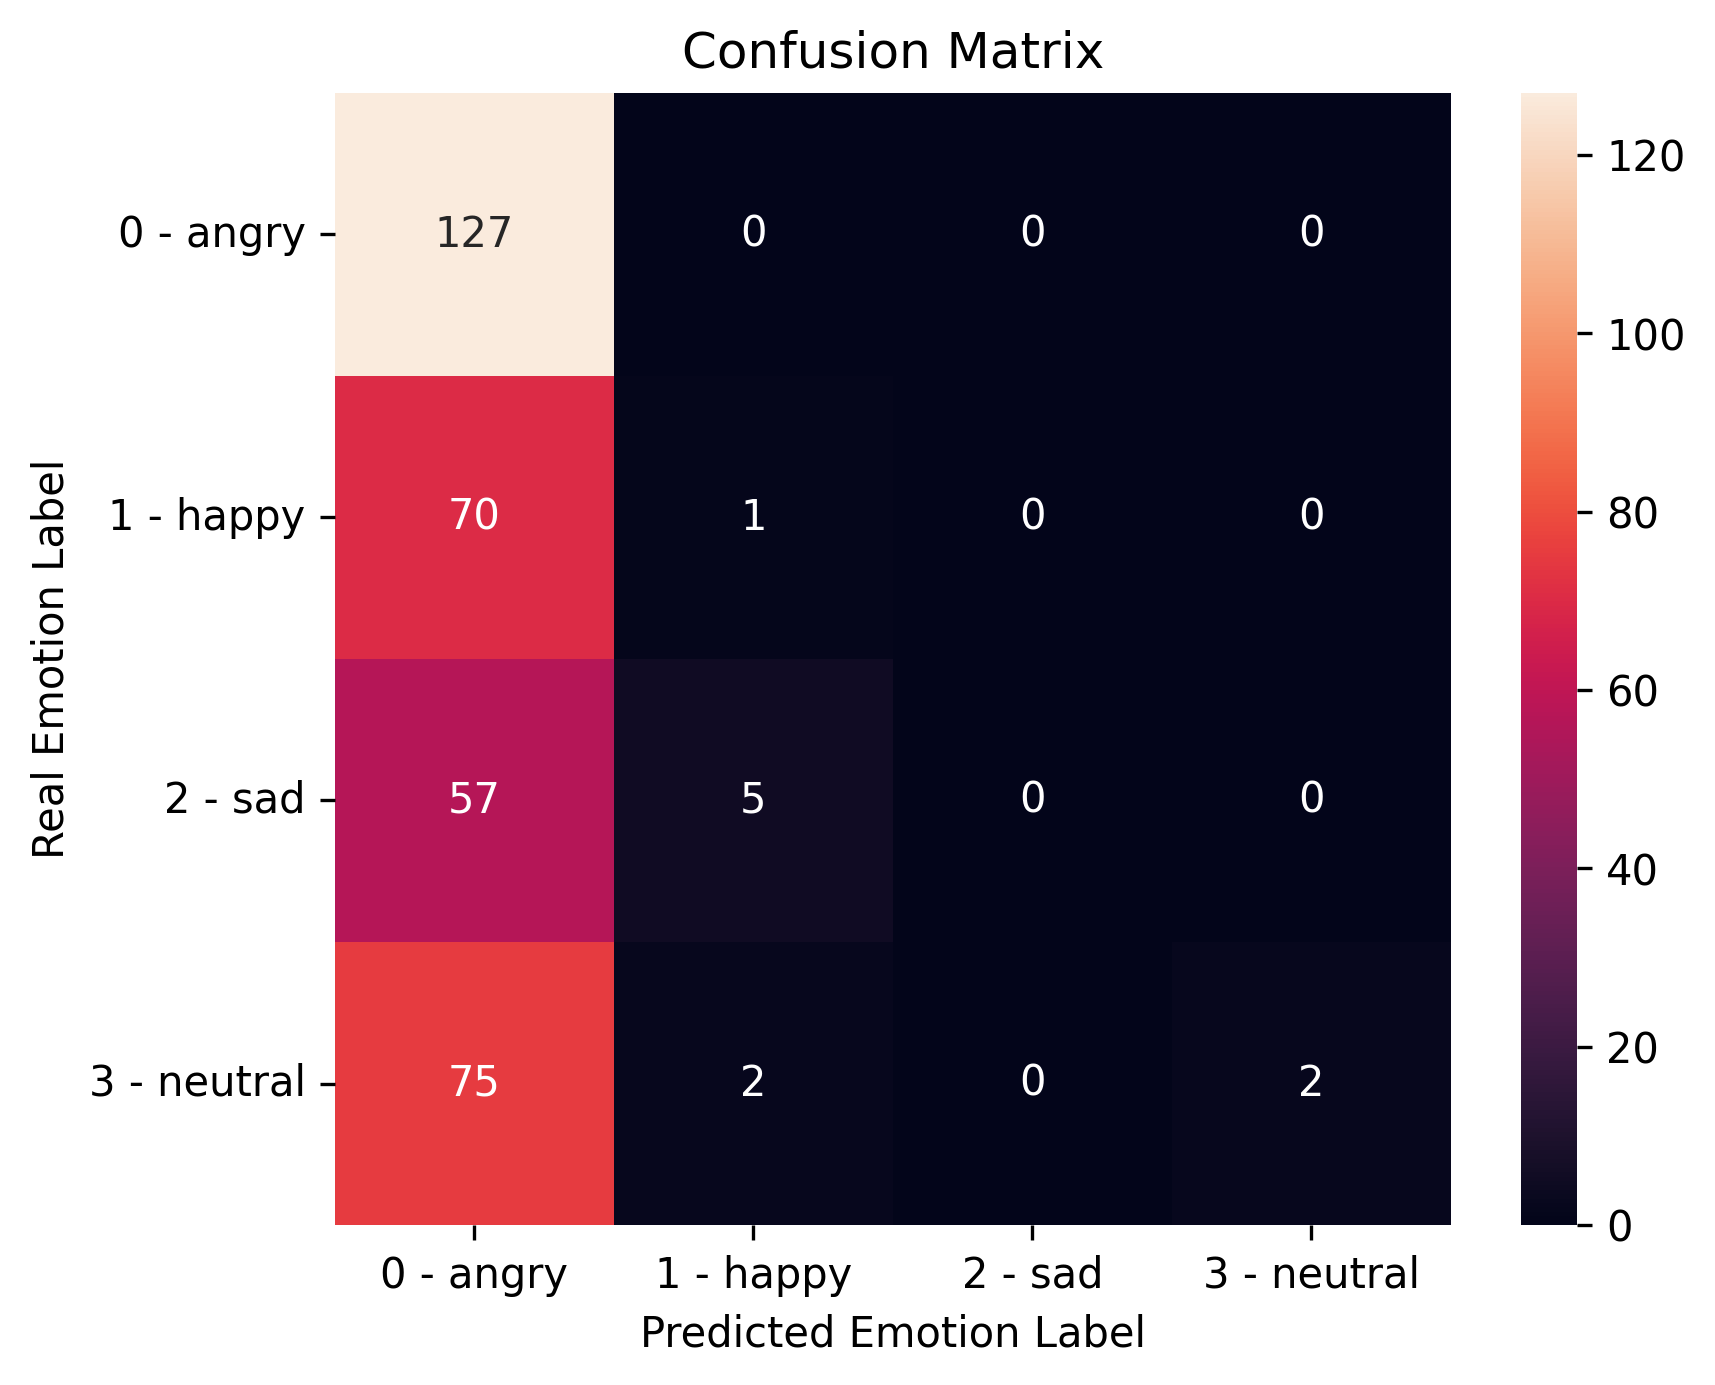

In [16]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{EMODB_DIR}*.wav")):
    emotion = file_path[-6:-5]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

## Stratified Deep Learning Model

100%|██████████| 535/535 [01:02<00:00,  8.62it/s]
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Metric                     Value
-----------------------  -------
Accuracy                  38.05
F1 score macro            15.22
Precision                 34.71
Recall                    25.63
Matthews corrcoef          0.052
Average Prediction Time    0.18

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       127
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00        62
           3       1.00      0.03      0.05        79

    accuracy                           0.38       339
   macro avg       0.35      0.26      0.15       339
weighted avg       0.38      0.38      0.22       339



C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


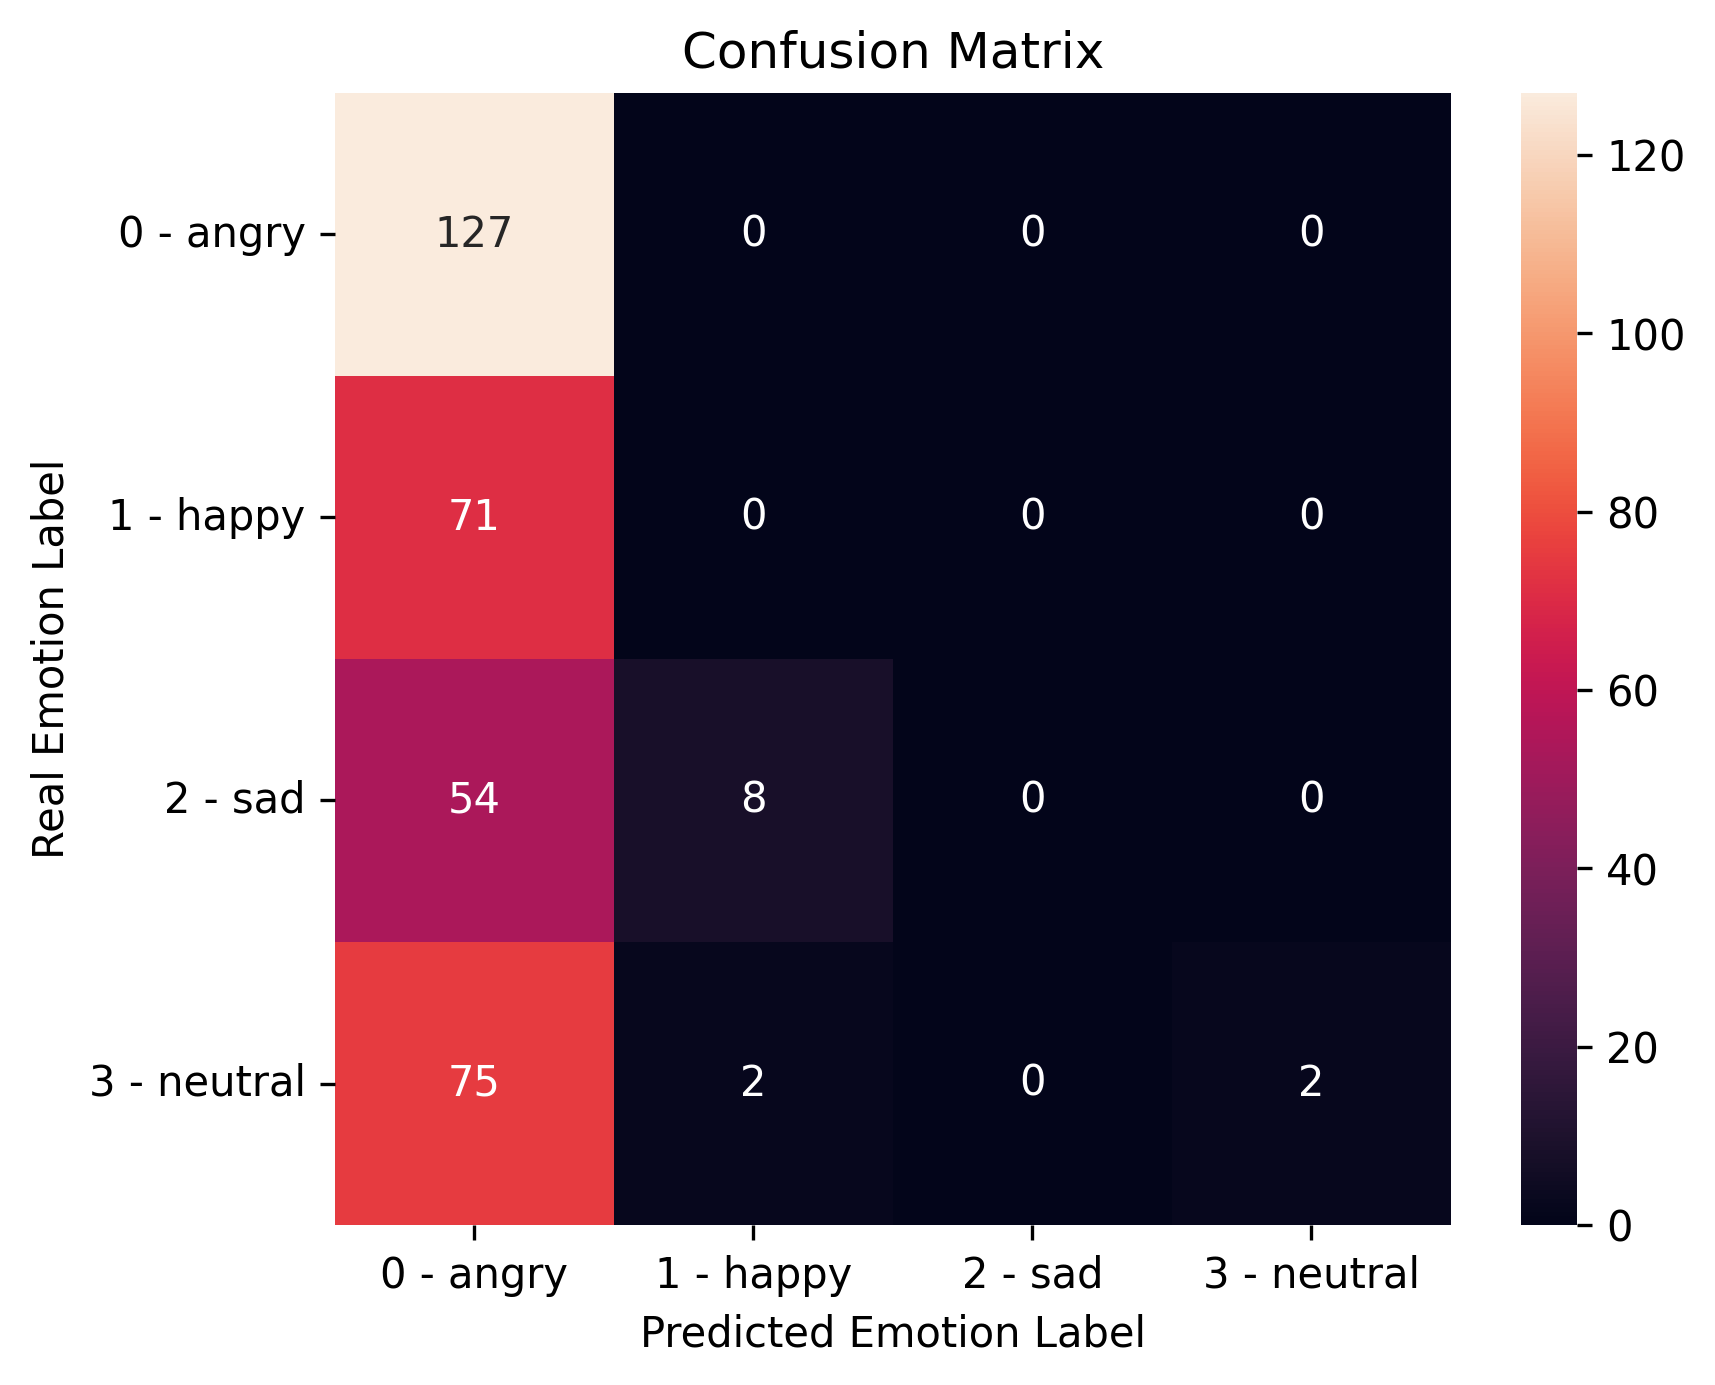

In [8]:
model = tf.keras.models.load_model('stratified_dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{EMODB_DIR}*.wav")):
    emotion = file_path[-6:-5]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

# CREMA-D

In [9]:
emotion_number = {
    'ANG': 0, 'HAP': 1, 'SAD': 2, 'NEU': 3
}

print(f"Number of Audio Files: {pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE).shape[0]}")
pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Number of Audio Files: 4898


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,1271
happy,1,1271
sad,2,1269
neutral,3,1087


In [18]:
print(tabulate(pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE).groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id"), headers=["Emotion", "Number of Files"], tablefmt='latex_booktabs'))

\begin{tabular}{lr}
\toprule
 Emotion        &   Number of Files \\
\midrule
 ('anger', 0)   &              1271 \\
 ('happy', 1)   &              1271 \\
 ('sad', 2)     &              1269 \\
 ('neutral', 3) &              1087 \\
\bottomrule
\end{tabular}


## Traditional Model

100%|██████████| 7441/7441 [08:10<00:00, 15.16it/s]



Metric                     Value
-----------------------  -------
Accuracy                  44.41
F1 score macro            35.45
Precision                 63.18
Recall                    46.12
Matthews corrcoef          0.335
Average Prediction Time    0.1

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1271
           1       0.56      0.14      0.22      1271
           2       1.00      0.00      0.00      1269
           3       0.33      0.92      0.49      1087

    accuracy                           0.44      4898
   macro avg       0.63      0.46      0.35      4898
weighted avg       0.64      0.44      0.35      4898



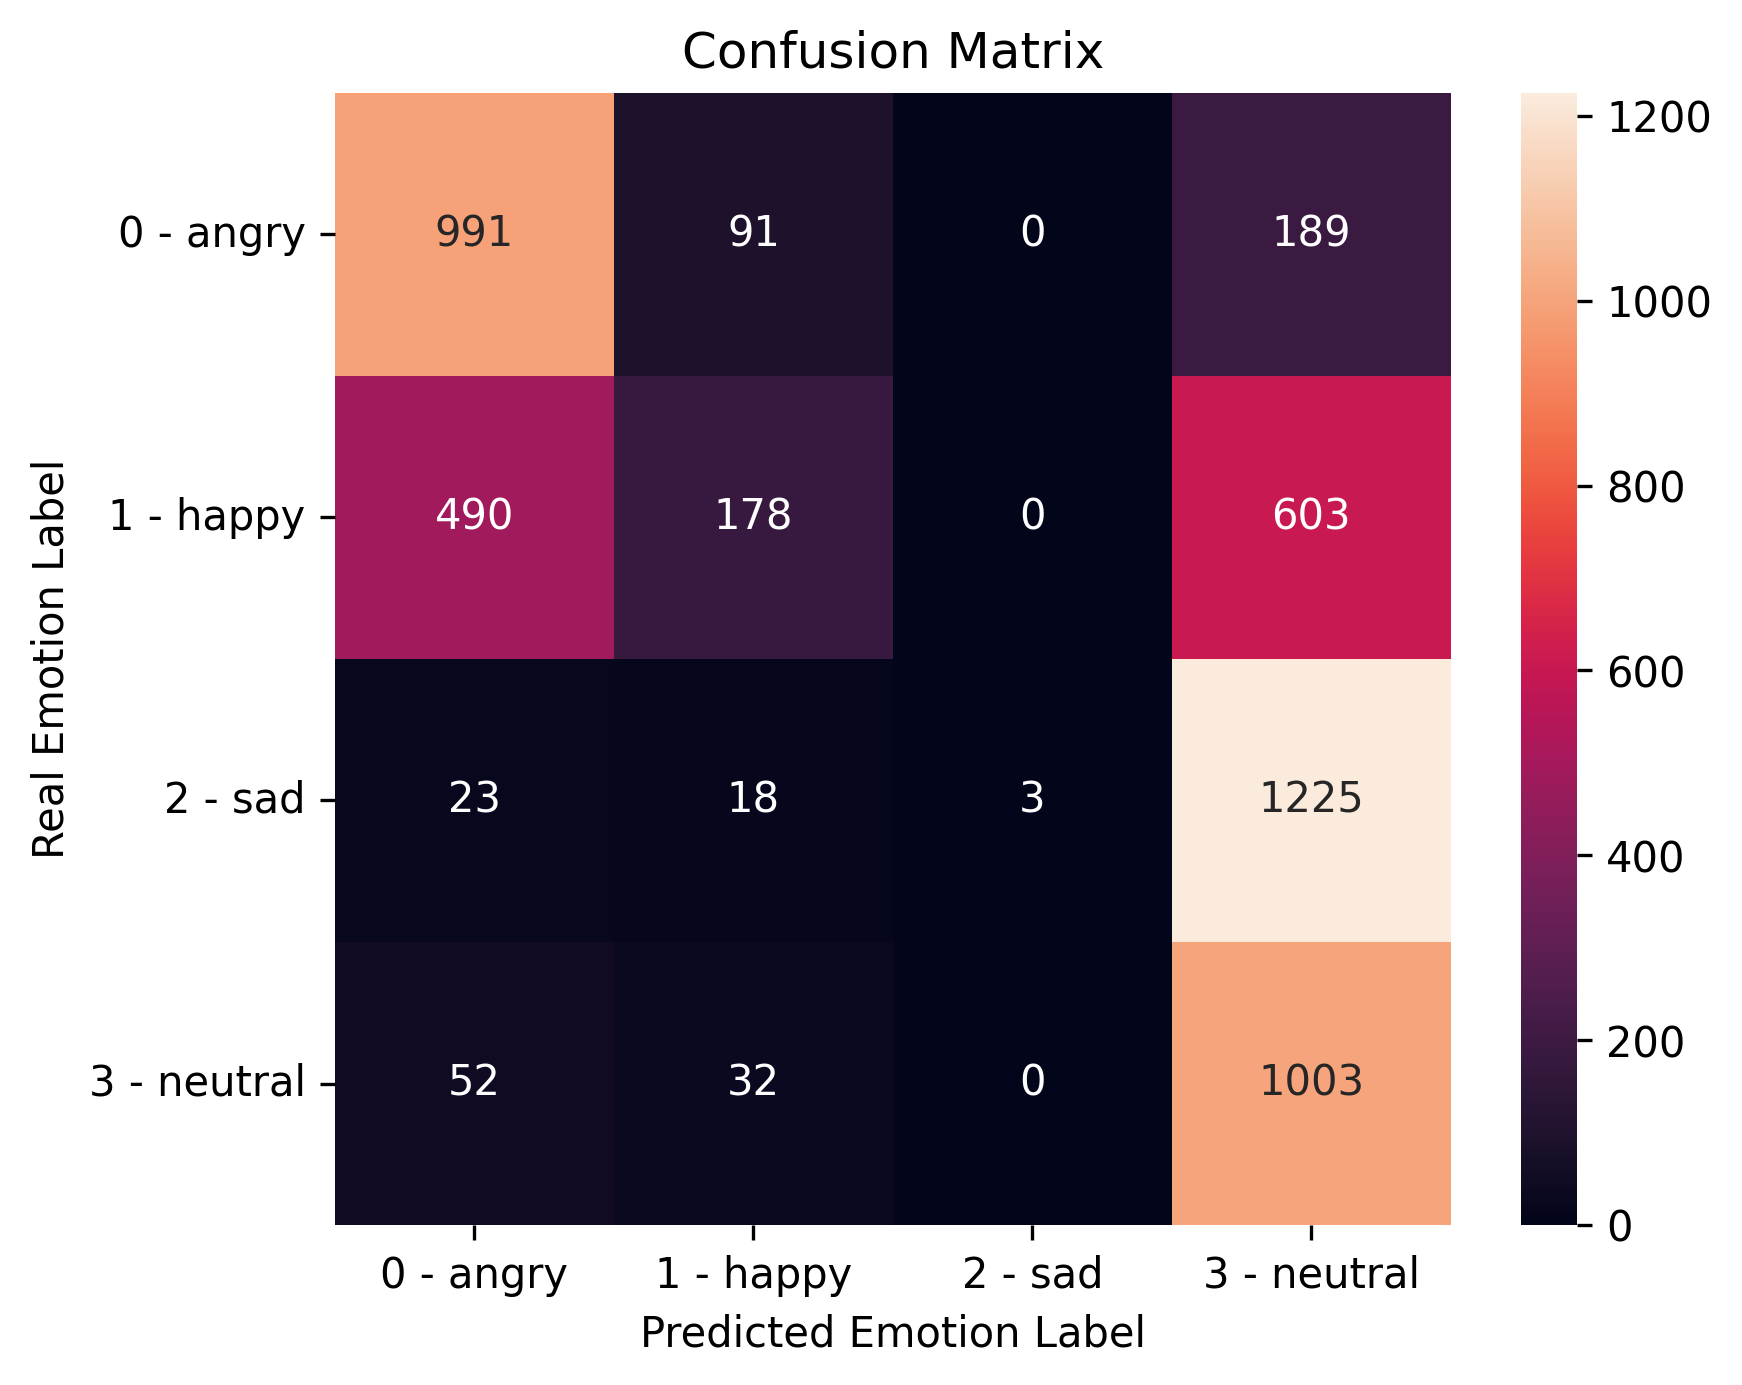

In [19]:
model = load('traditional_model.pkl')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{CREMAD_DIR}*.wav")):
    emotion = file_path[-10:-7]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    processed_data = extract_features(file_path)
    pred = model.predict(processed_data)
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(pred)
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(



Metric                     Value
-----------------------  -------
Accuracy                  44.41
F1 score macro            35.45
Precision                 63.18
Recall                    46.12
Matthews corrcoef          0.335
Average Prediction Time    0.1

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1271
           1       0.56      0.14      0.22      1271
           2       1.00      0.00      0.00      1269
           3       0.33      0.92      0.49      1087

    accuracy                           0.44      4898
   macro avg       0.63      0.46      0.35      4898
weighted avg       0.64      0.44      0.35      4898



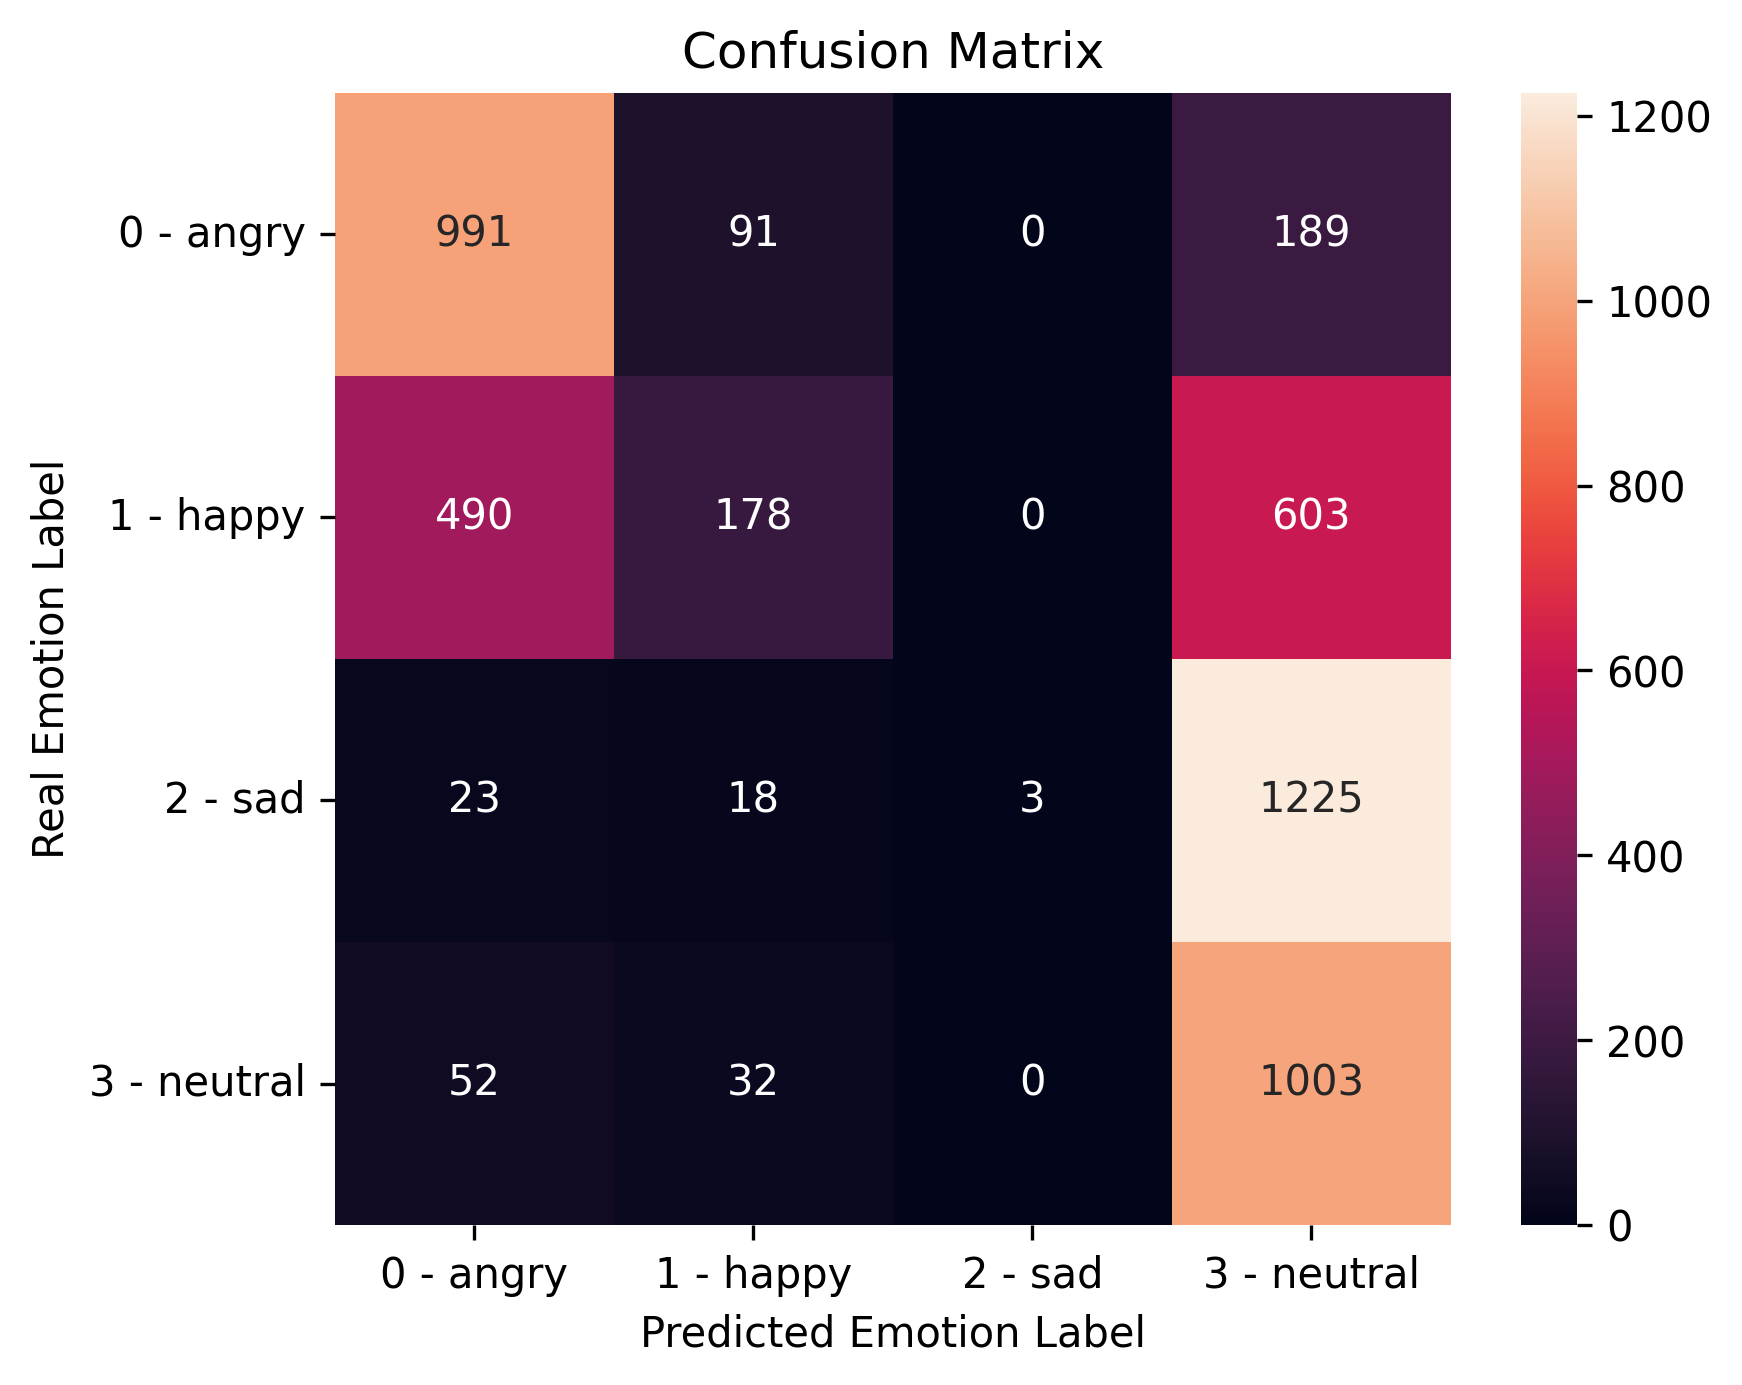

In [20]:
model = load('traditional_model.pkl')

df = pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE)
y = df.iloc[:, 4:5]
x = df.iloc[:, 5:]

start_time = time.time()
pred = model.predict(x)
times.append(time.time() - start_time)

get_metrics(y, pred, times)

## Stratified Traditional Model

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(



Metric                     Value
-----------------------  -------
Accuracy                  45.12
F1 score macro            37.5
Precision                 36.46
Recall                    46.54
Matthews corrcoef          0.323
Average Prediction Time    0.64

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1271
           1       0.50      0.24      0.33      1271
           2       0.00      0.00      0.00      1269
           3       0.34      0.85      0.49      1087

    accuracy                           0.45      4898
   macro avg       0.36      0.47      0.37      4898
weighted avg       0.37      0.45      0.37      4898



C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

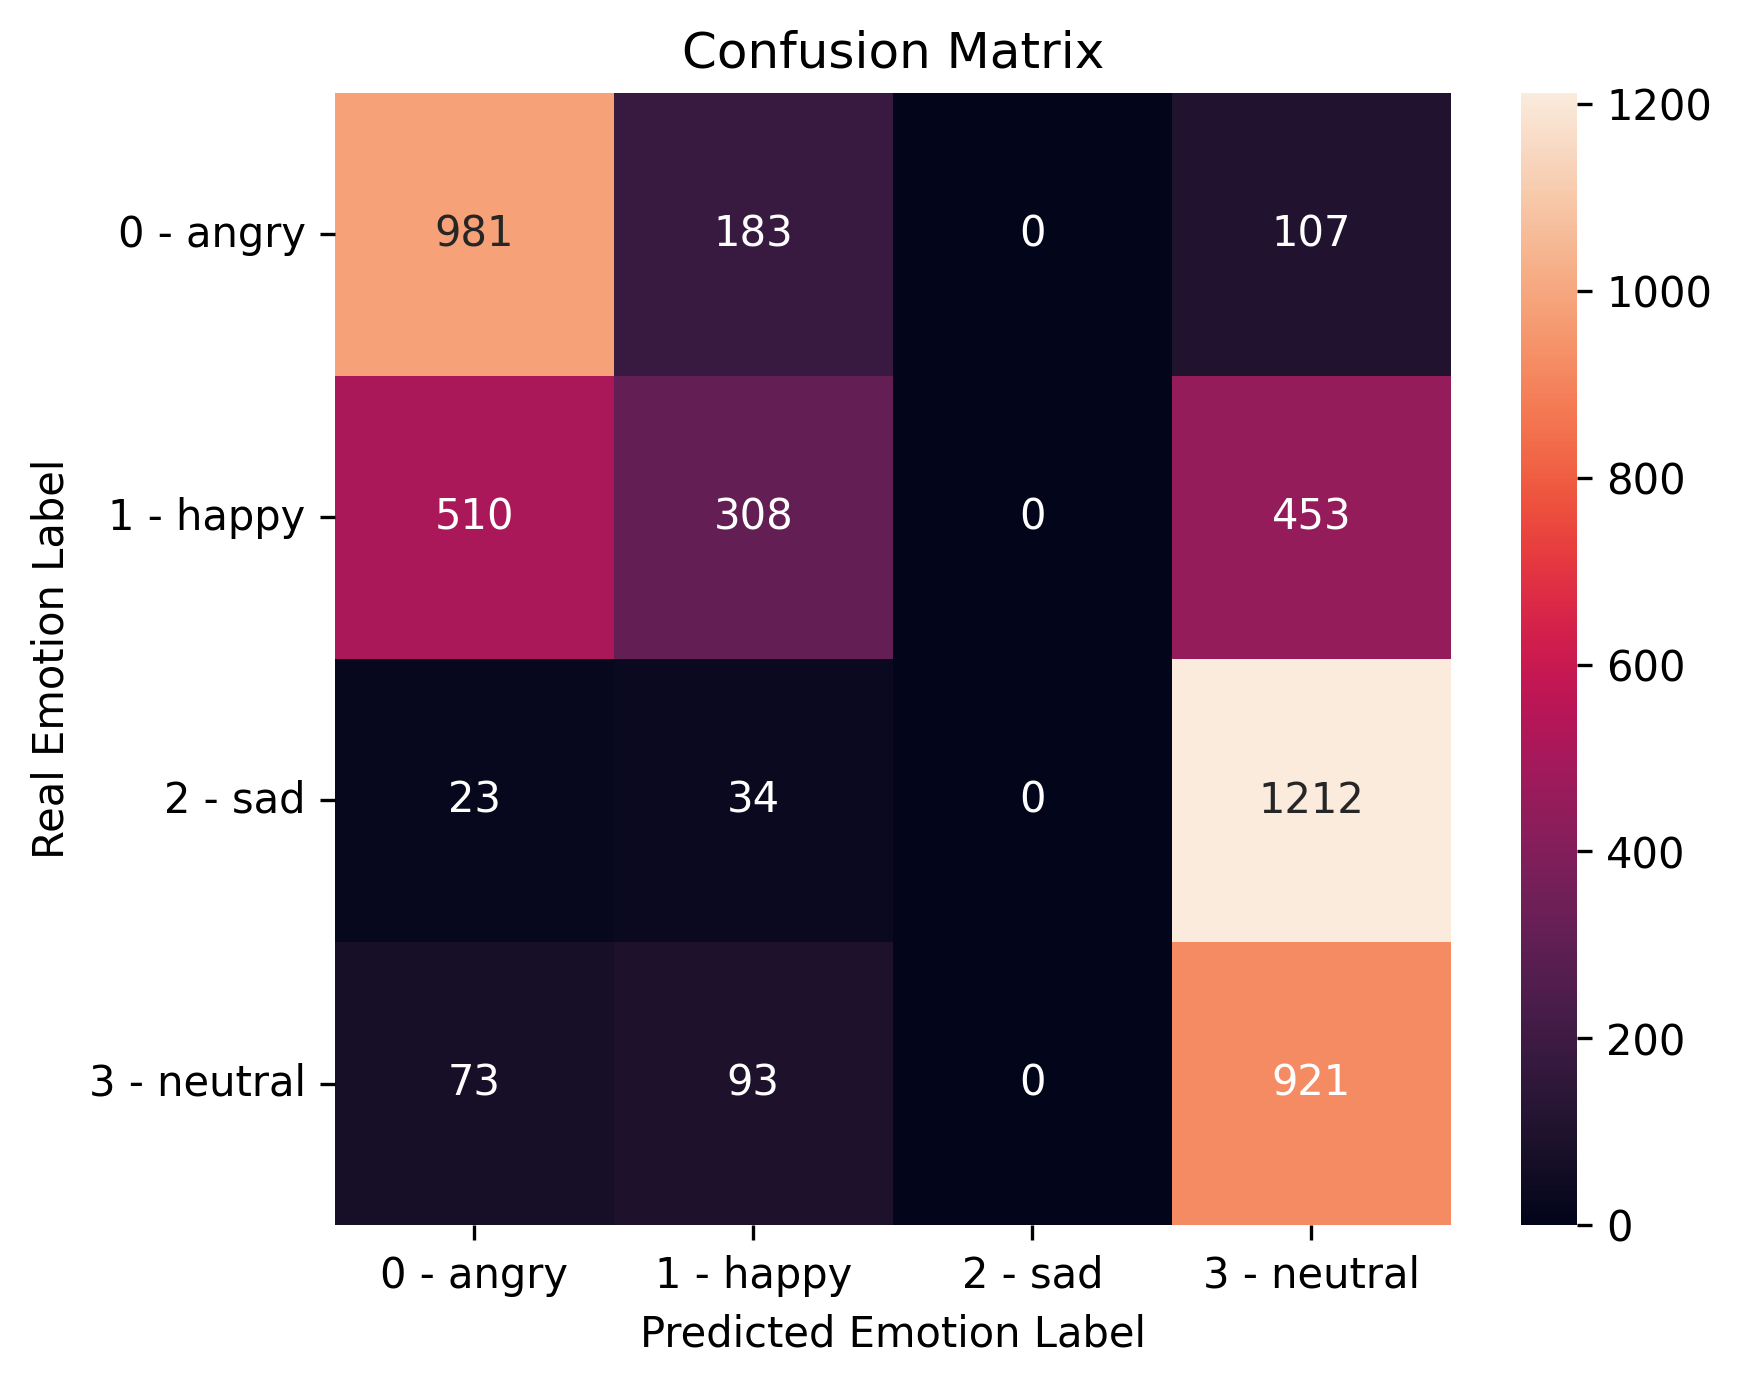

In [49]:
model = load('stratified_traditional_model.pkl')

df = pd.read_csv(CREMAD_EXTRACTED_FEATURES_FILE)
y = df.iloc[:, 4:5]
x = df.iloc[:, 5:]
times = []

start_time = time.time()
pred = model.predict(x)
times.append(time.time() - start_time)

get_metrics(y, pred, times)

## Deep Learning Model

100%|██████████| 7441/7441 [52:36<00:00,  2.36it/s]



Metric                     Value
-----------------------  -------
Accuracy                  54.14
F1 score macro            47.71
Precision                 51.68
Recall                    52.98
Matthews corrcoef          0.407
Average Prediction Time    0.64

              precision    recall  f1-score   support

           0       0.55      0.88      0.68      1271
           1       0.44      0.17      0.25      1271
           2       0.56      0.85      0.68      1269
           3       0.51      0.22      0.30      1087

    accuracy                           0.54      4898
   macro avg       0.52      0.53      0.48      4898
weighted avg       0.52      0.54      0.48      4898



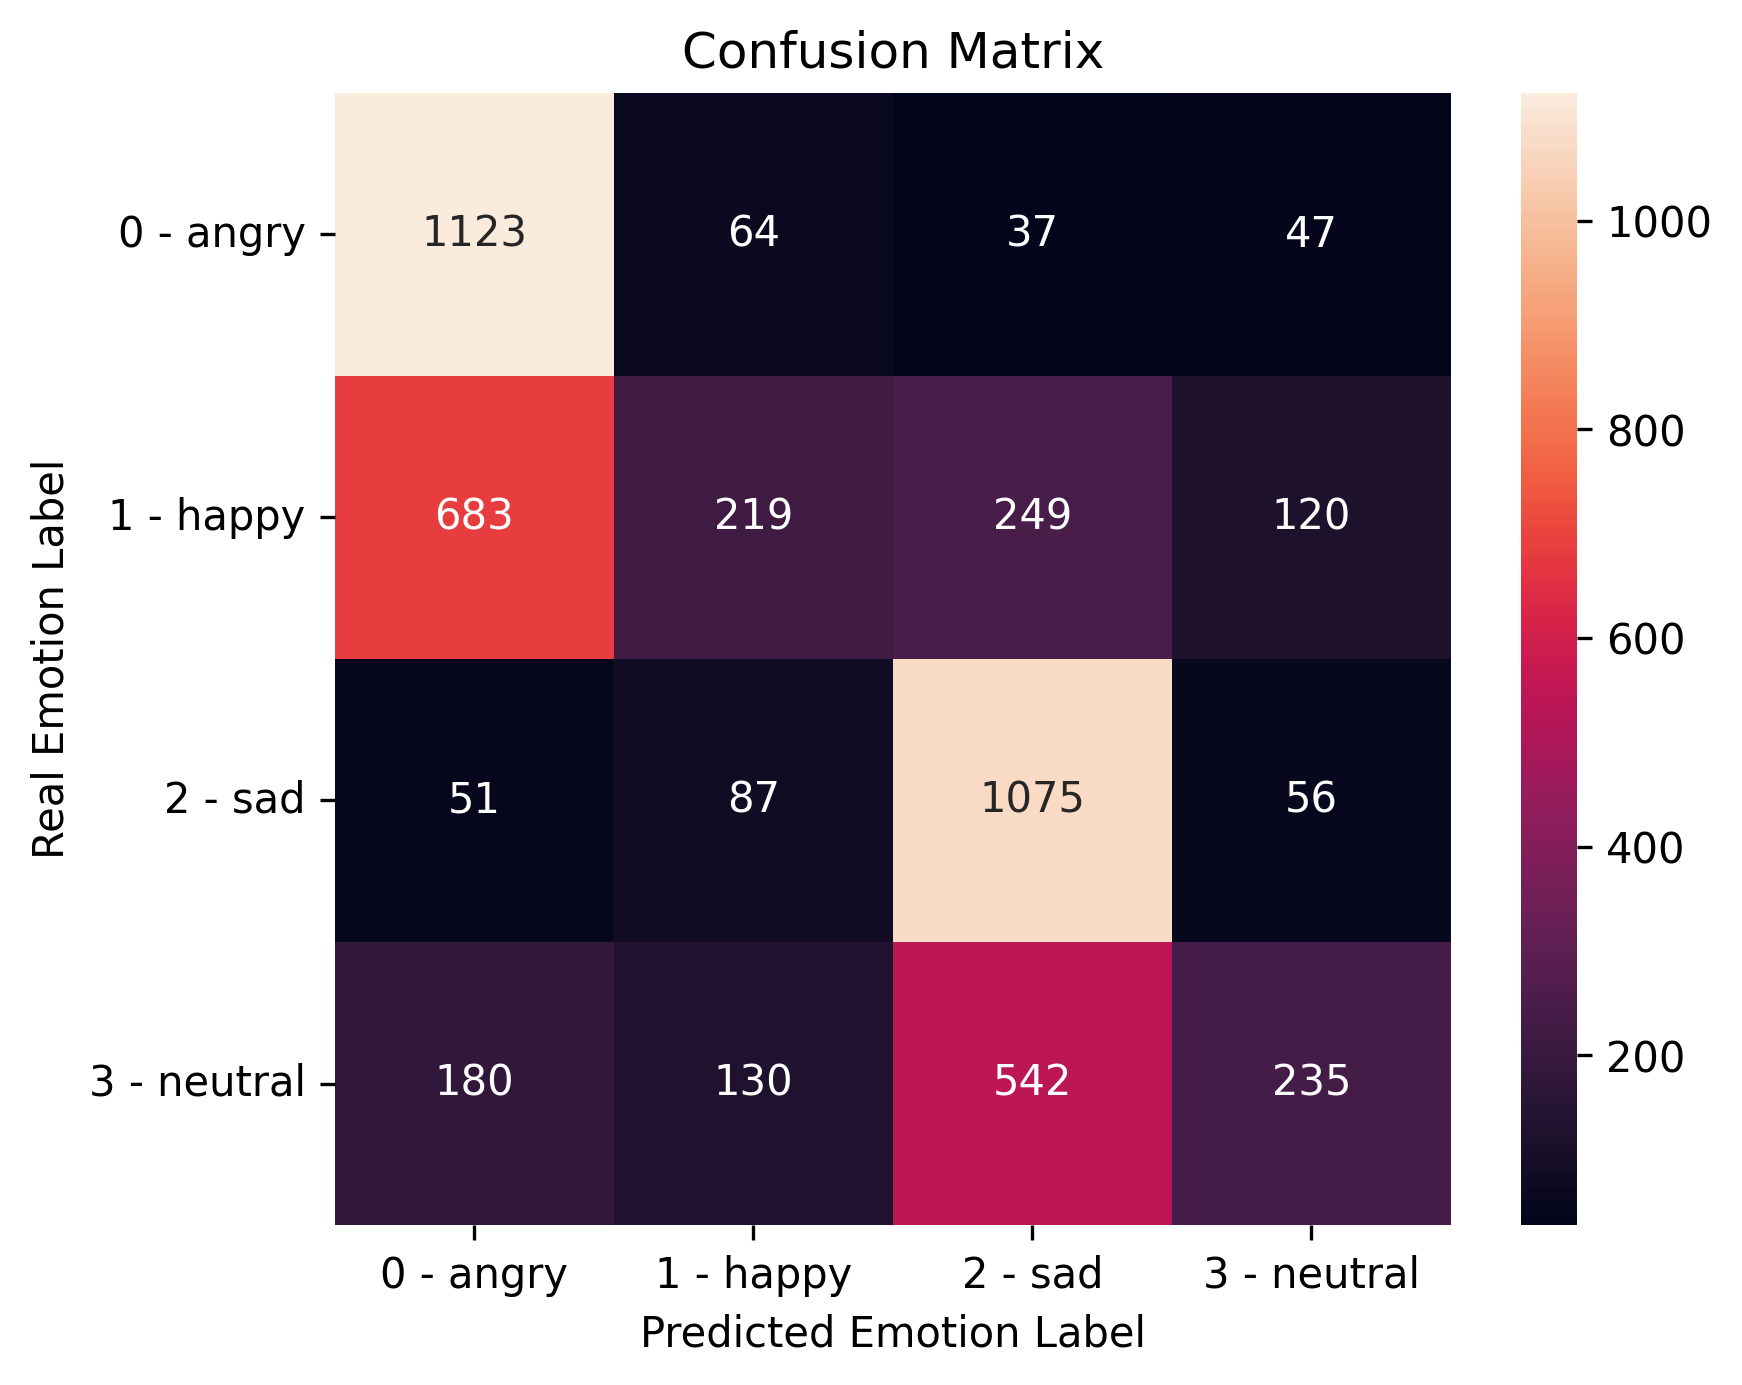

In [22]:
model = tf.keras.models.load_model('dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{CREMAD_DIR}*.wav")):
    emotion = file_path[-10:-7]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)

## Stratified Deep Learning Model

100%|██████████| 7441/7441 [00:00<00:00, 3717667.19it/s]



Metric                     Value
-----------------------  -------
Accuracy                  55.29
F1 score macro            50.06
Precision                 54.11
Recall                    54.05
Matthews corrcoef          0.417
Average Prediction Time    0.64

              precision    recall  f1-score   support

           0       0.55      0.90      0.68      1271
           1       0.42      0.26      0.32      1271
           2       0.61      0.79      0.69      1269
           3       0.58      0.21      0.31      1087

    accuracy                           0.55      4898
   macro avg       0.54      0.54      0.50      4898
weighted avg       0.54      0.55      0.51      4898



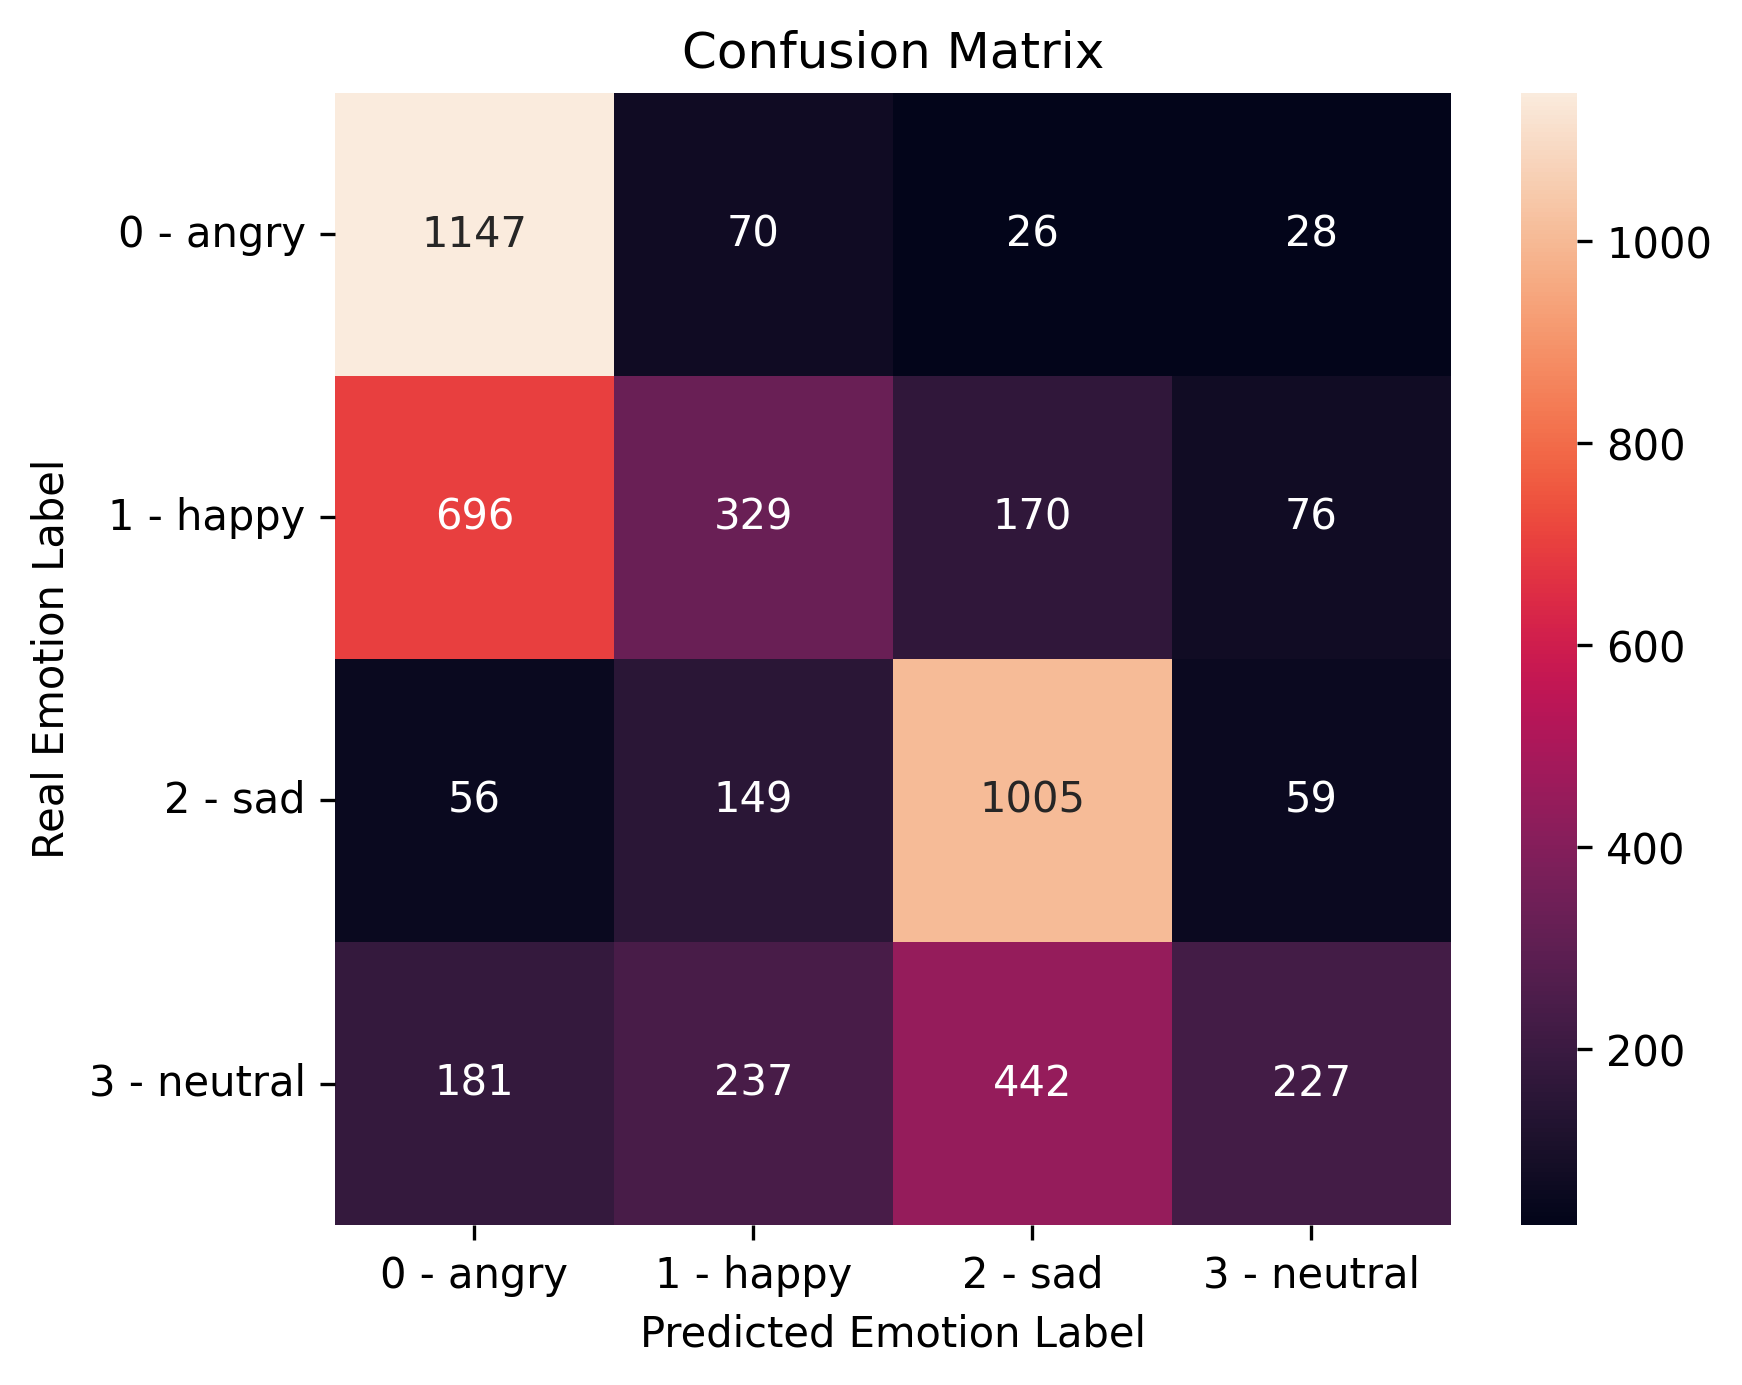

In [34]:
model = tf.keras.models.load_model('stratified_dl_model.h5')

y_labels = []
y_pred = []
times = []

for file_path in tqdm(glob.glob(f"{CREMAD_DIR}*.wav")):
    emotion = file_path[-10:-7]

    if emotion not in emotion_number:
        continue
    
    start_time = time.time()
    spec = extract_dl_features(file_path)
    pred = model.predict(spec, verbose=0)[0]
    end_time = time.time() - start_time

    times.append(end_time)
    y_pred.append(list(pred).index(max(pred)))
    y_labels.append(emotion_number[emotion])

get_metrics(y_labels, y_pred, times)